In [1]:
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from joblib import Parallel, delayed
import os

import dag_utils as utils
from Baselines import Nonneg_dagma, MetMulDagma
from TopoGreedy import TopoGreedy, TopoGreedy_refresh
from Baselines import colide_ev
from Baselines import DAGMA_linear
from Baselines import notears_linear


PATH = './results/samples/'
SAVE = True 
SEED = 10
N_CPUS = os.cpu_count()  # Get number of available CPUs
np.random.seed(SEED)

In [2]:
# Experiment function
def get_lamb_value(n_nodes, n_samples, times=1):
    return np.sqrt(np.log(n_nodes) / n_samples) * times 

def run_samples_exp(g, data_p, N_samples, exps, thr=.2, verb=False):
    shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Theta_est = [np.zeros((len(N_samples), len(exps)))  for _ in range(9)]
    W_est_all = np.zeros((len(N_samples), len(exps), data_p['n_nodes'], data_p['n_nodes']))
    
    for i, n_samples in enumerate(N_samples):
        if g % N_CPUS == 0:
            print(f'Graph: {g+1}, samples: {n_samples}')

        # Create data
        data_p_aux = data_p.copy()
        data_p_aux['n_samples'] = n_samples

        W_true, _, X, Theta_true = utils.simulate_sem(**data_p_aux)
        X_std = utils.standarize(X) if 'standarize' in data_p.keys() and data_p['standarize'] else X
        W_true_bin = utils.to_bin(W_true, thr)
        norm_W_true = np.linalg.norm(W_true)
        emp_cov = (X_std.T @ X_std) / float(X_std.shape[0])

        for j, exp in enumerate(exps):
            X_aux = X_std if 'standarize' in exp.keys() and exp['standarize'] else X


            arg_aux = exp['args'].copy()
            if 'adapt_lamb' in exp.keys() and exp['adapt_lamb']:
                if 'lamb' in arg_aux.keys():
                    arg_aux['lamb'] = get_lamb_value(data_p['n_nodes'], n_samples, arg_aux['lamb'])
                elif 'lambda1' in arg_aux.keys():
                    arg_aux['lambda1'] = get_lamb_value(data_p['n_nodes'], n_samples, arg_aux['lambda1'])

            if exp['model'] == notears_linear:
                t_init = perf_counter()
                W_est = notears_linear(X_aux, **arg_aux)
                t_end = perf_counter()

            elif exp['model'] == TopoGreedy_refresh:
                t_init = perf_counter()
                out = TopoGreedy_refresh(X_aux, emp_cov, **arg_aux)
                t_end = perf_counter()
                W_est = out['A_est']
                Theta_est = out['prec']
                W_est_bin = out['A_est_bin']

            else:

                model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
                t_init = perf_counter()
                model.fit(X, **arg_aux)
                t_end = perf_counter()
                W_est = model.W_est
                Theta_est = model.Theta_est if model == TopoGreedy else np.zeros_like(Theta_true)
                

            if np.isnan(W_est).any():
                W_est = np.zeros_like(W_est)
                W_est_bin = np.zeros_like(W_est)
            else:
                W_est_bin = utils.to_bin(W_est, thr)
            
            W_est_bin = W_est_bin.T if exp['model'] == TopoGreedy else W_est_bin
            W_est = W_est.T if exp['model'] == TopoGreedy else W_est

            # Store the estimated adjacency matrix
            W_est_all[i, j] = W_est

            shd[i,j], tpr[i,j], fdr[i,j] = utils.count_accuracy(W_true_bin, W_est_bin)
            fscore[i,j] = f1_score(W_true_bin.flatten(), W_est_bin.flatten())
            err[i,j] = utils.compute_norm_sq_err(W_true, W_est, norm_W_true)
            # acyc[i,j] = model.dagness(W_est) if hasattr(model, 'dagness') else 1
            Theta_est[i,j] = np.linalg.norm(Theta_est - Theta_true, 'fro') / (np.linalg.norm(Theta_true, 'fro') + 1e-8)
            runtime[i,j] = t_end - t_init
            dag_count[i,j] += 1 if utils.is_dag(W_est_bin) else 0
        
            if verb and (g % N_CPUS == 0):

                print(f'-{exp["leg"]}: shd {shd[i,j]}  -  err: {err[i,j]}  -  Theta diff: {Theta_est[i,j]:.3f}  -  time: {runtime[i,j]:.3f}')

    return shd, tpr, fdr, fscore, err, runtime, dag_count, Theta_est, W_true, W_est_all

In [3]:
N_trials = 10

n_dags = 8 * N_trials
N_samples = [1000]

# DEFINE EXPERIMENTS
Exps = [
  # TopoGreedy with more iterations but looser tolerance
  {'model': TopoGreedy_refresh, 'args': {'k_list': [102], 'threshold_list': [1e-4], 'topo_thr': 0.5, 'refresh_every': 0.04}, 'fmt': '^-', 'leg': 'TopoGreedy-0.02'},


  {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
   'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': 'v--', 'leg': 'CoLiDe-Fix'},


  {'model': DAGMA_linear, 'init': {'loss_type': 'l2'}, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .8],
   'warm_iter': 2e4, 'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': '^-', 'leg': 'DAGMA'},


]

In [1]:
N = 100
thr = .5
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': ((0.5, 2)),
    'var': 1,
}
# Initialize result lists to store metrics for each experiment
shd_results = []
tpr_results = []
fdr_results = []
fscore_results = []
err_results = []
runtime_results = []
dag_count_results = []
Theta_est_results = []

# Run experiments sequentially
t_init = perf_counter()
for g in range(n_dags):
    result = run_samples_exp(g, data_p, N_samples, Exps, thr, verb)
    shd_g, tpr_g, fdr_g, fscore_g, err_g, runtime_g, dag_count_g, Theta_est_g, W_true_g , W_est_all_g= result
    
    # Append results for this graph
    shd_results.append(shd_g)
    tpr_results.append(tpr_g)
    fdr_results.append(fdr_g)
    fscore_results.append(fscore_g)
    err_results.append(err_g)
    runtime_results.append(runtime_g)
    dag_count_results.append(dag_count_g)
    Theta_est_results.append(Theta_est_g)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

# Convert lists to arrays for final results
shd = np.array(shd_results)
tpr = np.array(tpr_results)
fdr = np.array(fdr_results)
fscore = np.array(fscore_results)
err = np.array(err_results)
runtime = np.array(runtime_results)
dag_count = np.array(dag_count_results)
Theta_est = np.array(Theta_est_results)

NameError: name 'perf_counter' is not defined

In [3]:
def _to_jsonable(obj):
    """Recursively convert objects to JSON-serializable forms."""
    import numpy as np
    from pathlib import Path

    # basic types
    if obj is None or isinstance(obj, (bool, int, float, str)):
        # cast numpy scalars to Python
        if isinstance(obj, (np.bool_, np.integer, np.floating)):
            return obj.item()
        return obj

    # numpy arrays -> lists (careful for huge arrays: we won't dump arrays here)
    if isinstance(obj, np.ndarray):
        return obj.tolist()

    # tuples -> lists
    if isinstance(obj, tuple):
        return [_to_jsonable(x) for x in obj]

    # lists
    if isinstance(obj, list):
        return [_to_jsonable(x) for x in obj]

    # dicts
    if isinstance(obj, dict):
        return {str(k): _to_jsonable(v) for k, v in obj.items()}

    # Path
    if isinstance(obj, Path):
        return str(obj)

    # dataclasses
    try:
        from dataclasses import is_dataclass, asdict
        if is_dataclass(obj):
            return _to_jsonable(asdict(obj))
    except Exception:
        pass

    # callables (functions/classes)
    if callable(obj):
        # try to capture module + name; fall back to repr
        name = getattr(obj, "__name__", obj.__class__.__name__)
        mod  = getattr(obj, "__module__", None)
        return f"{mod+'.' if mod else ''}{name}"

    # objects with __dict__
    if hasattr(obj, "__dict__"):
        return _to_jsonable(vars(obj))

    # fallback
    return repr(obj)


In [4]:
# -*- coding: utf-8 -*-
"""
Structured DAG experiments: data simulation -> baselines -> metrics -> save & return.

Assumes the following are available in scope or importable:
  - utils.simulate_sem, utils.standarize, utils.to_bin, utils.count_accuracy, utils.compute_norm_sq_err
  - TopoGreedy_refresh, DAGMA_linear, colide_ev, notears_linear
"""

from __future__ import annotations
import os, json, math, uuid, shutil, datetime as dt
from dataclasses import dataclass, asdict, field
from pathlib import Path
from time import perf_counter
from typing import Callable, Dict, Any, List, Optional, Tuple

import numpy as np
from sklearn.metrics import f1_score
from Baselines import GOLEM_Torch
import matplotlib.pyplot as plt

# ---------------------------------------------
# Utility: lambda schedule
# ---------------------------------------------
def get_lambda_value(n_nodes: int, n_samples: int, times: float = 1.0) -> float:
    """Common λ heuristic: sqrt(log p / n) scaled by `times`."""
    return math.sqrt(max(1e-12, np.log(max(2, n_nodes))) / max(2, n_samples)) * times


# ---------------------------------------------
# Baseline spec & registry
# ---------------------------------------------
@dataclass
class BaselineSpec:
    """
    Unified baseline configuration.

    - model: either a *callable estimator* with .fit() method (class) OR a function (e.g., notears_linear)
    - init: kwargs passed to class constructor (ignored if model is a function)
    - args: kwargs passed to .fit(...) or function call
    - name: label for legends / saving
    - standardize: if True, pass standardized X to the model; else pass raw X
    - adapt_lambda: if True, rescale 'lamb' or 'lambda1' in args per (p, n)
    - topo_transpose: if True, transpose W_est and binarized variant to align with your downstream expectations
                      (e.g., TopoGreedy variants that output transposed)
    - is_topogreedy_refresh: if True, expects dict output with keys {"prec","A_est","A_est_bin"}; handled specially
    """
    model: Any
    init: Dict[str, Any] = field(default_factory=dict)
    args: Dict[str, Any] = field(default_factory=dict)
    name: str = "baseline"
    standardize: bool = False
    adapt_lambda: bool = False
    topo_transpose: bool = False
    is_topogreedy_refresh: bool = False


# ---------------------------------------------
# Experiment runner
# ---------------------------------------------
@dataclass
class ExperimentConfig:
    n_graphs: int
    n_nodes: int
    n_samples_list: List[int]
    edge_threshold: float
    data_params: Dict[str, Any]
    baselines: List[BaselineSpec]
    out_dir: str = "./exp_results"
    run_tag: Optional[str] = None
    save_intermediate: bool = True
    seed_offset: int = 0  # to vary graph seeds across runs


class ExperimentRunner:
    def __init__(self, cfg: ExperimentConfig):
        self.cfg = cfg
        self.run_id = cfg.run_tag or dt.datetime.now().strftime("%Y%m%d_%H%M%S") + "_" + uuid.uuid4().hex[:6]
        self.out_root = Path(cfg.out_dir) / self.run_id
        self.out_root.mkdir(parents=True, exist_ok=True)
        self._save_manifest()

    # ---------- public API ----------
    def run(self, verbose: bool = True):
        """
        Orchestrates:
          - for each graph (with new simulation seed),
          - for each n_samples in list,
          - for each baseline,
            => train / estimate => metrics => save.

        Returns a dict of stacked arrays ready-to-plot.
        """
        B = len(self.cfg.baselines)
        S = len(self.cfg.n_samples_list)
        N = self.cfg.n_nodes
        G = self.cfg.n_graphs

        # Metrics tensors: (G, S, B)
        shd = np.zeros((G, S, B))
        tpr = np.zeros((G, S, B))
        fdr = np.zeros((G, S, B))
        fscore = np.zeros((G, S, B))
        err = np.zeros((G, S, B))
        runtime = np.zeros((G, S, B))
        dag_count = np.zeros((G, S, B))
        # Frobenius diff(Theta): normalized (G, S, B)
        theta_diff = np.zeros((G, S, B))

        # Store full adjacency estimates: (G, S, B, N, N)
        W_est_all = np.zeros((G, S, B, N, N))
        # Optional precision matrices when available (fill zeros otherwise)
        Theta_est_all = np.zeros((G, S, B, N, N))

        for g in range(G):
            if verbose:
                print(f"\n=== Graph {g+1}/{G} ===")

            # -------------------- simulate data for this graph --------------------
            graph_seed = self.cfg.seed_offset + g
            data_p = dict(self.cfg.data_params)
            data_p["n_nodes"] = self.cfg.n_nodes

            # we will re-simulate for each n_samples (fresh X but same W_true structure per spec)
            W_true_cache = None
            Theta_true_cache = None

            for si, n_samples in enumerate(self.cfg.n_samples_list):
                data_p_this = dict(data_p)
                data_p_this["n_samples"] = int(n_samples)

                # simulate SEM
                W_true, _, X, Theta_true = utils.simulate_sem(**data_p_this)

                # cache structure (if consistent across n_samples) — harmless if overwritten
                W_true_cache = W_true
                Theta_true_cache = Theta_true

                X_std = utils.standarize(X) if data_p_this.get("standarize", False) else X
                W_true_bin = utils.to_bin(W_true, self.cfg.edge_threshold)
                norm_W_true = np.linalg.norm(W_true)
                emp_cov = (X_std.T @ X_std) / float(X_std.shape[0])
                print(f"cond: {np.linalg.cond(Theta_true)}")
                if verbose:
                    print(f"- samples={n_samples}, edges≈{np.count_nonzero(W_true_bin)}")

                # -------------------- run all baselines --------------------
                for bi, base in enumerate(self.cfg.baselines):
                    X_in = X_std if base.standardize else X
                    # args per baseline (copy so we can mutate lambdas safely)
                    args_call = dict(base.args)

                    # adaptive λ scheduling
                    if base.adapt_lambda:
                        if "lamb" in args_call:
                            args_call["lamb"] = get_lambda_value(self.cfg.n_nodes, n_samples, args_call["lamb"])
                        if "lambda1" in args_call:
                            args_call["lambda1"] = get_lambda_value(self.cfg.n_nodes, n_samples, args_call["lambda1"])

                    # ---------- execute baseline ----------
                    t0 = perf_counter()
                    W_est, Theta_est = self._run_one_baseline(
                        base=base,
                        X=X_in,
                        X_std=X_std,
                        emp_cov=emp_cov,
                        edge_thr=self.cfg.edge_threshold
                    )
                    t1 = perf_counter()

                    # NaN safeguard
                    if np.isnan(W_est).any():
                        W_est = np.zeros_like(W_est)
                        W_bin = np.zeros_like(W_est)
                    else:
                        W_bin = utils.to_bin(W_est, self.cfg.edge_threshold)

                    # Optional orientation fix for TopoGreedy-like outputs
                    if base.topo_transpose:
                        W_est = W_est.T
                        W_bin = W_bin.T

                    # ---------- metrics ----------
                    shd[g, si, bi], tpr[g, si, bi], fdr[g, si, bi] = utils.count_accuracy(W_true_bin, W_bin)
                    fscore[g, si, bi] = f1_score(W_true_bin.flatten(), W_bin.flatten())
                    err[g, si, bi] = utils.compute_norm_sq_err(W_true, W_est, norm_W_true)
                    runtime[g, si, bi] = (t1 - t0)
                    dag_count[g, si, bi] = 1.0 if utils.is_dag(W_bin) else 0.0

                    # Theta Frobenius difference (if Theta_est available)
                    if Theta_est is None:
                        theta_diff[g, si, bi] = 0.0
                    else:
                        num = np.linalg.norm(Theta_est - Theta_true, "fro")
                        den = np.linalg.norm(Theta_true, "fro") + 1e-8
                        theta_diff[g, si, bi] = num / den

                    # store estimates
                    W_est_all[g, si, bi] = W_est
                    if Theta_est is not None:
                        Theta_est_all[g, si, bi] = Theta_est

                    if verbose:
                        print(f"  · {base.name:<18s} | SHD {shd[g,si,bi]:.1f} | F1 {fscore[g,si,bi]:.3f} | "
                              f"ΘΔ {theta_diff[g,si,bi]:.3f} | {runtime[g,si,bi]:.2f}s")

                # optional per-(graph,samples) checkpoint save
                if self.cfg.save_intermediate:
                    self._save_block(
                        g=g, si=si,
                        W_true=W_true, Theta_true=Theta_true,
                        W_est_all=W_est_all[g, si],
                        Theta_est_all=Theta_est_all[g, si],
                        shd=shd[g, si], tpr=tpr[g, si], fdr=fdr[g, si],
                        f1=fscore[g, si], err=err[g, si], rt=runtime[g, si],
                        dags=dag_count[g, si], theta_diff=theta_diff[g, si]
                    )

        # ------------- stack & save final -------------
        final = dict(
            shd=shd, tpr=tpr, fdr=fdr, f1=fscore, err=err,
            runtime=runtime, dag_count=dag_count, theta_diff=theta_diff,
            W_est_all=W_est_all, Theta_est_all=Theta_est_all
        )
        np.savez_compressed(self.out_root / "final_results.npz", **final)
        if verbose:
            print(f"\nSaved results to: {self.out_root}")

        return final

    # ---------- internals ----------
    def _run_one_baseline(
        self,
        base: BaselineSpec,
        X: np.ndarray,
        X_std: np.ndarray,
        emp_cov: np.ndarray,
        edge_thr: float
    ) -> Tuple[np.ndarray, Optional[np.ndarray]]:
        """
        Runs a single baseline and returns (W_est, Theta_est or None).

        Special handling:
          - function baselines (e.g., notears_linear): W_est = f(X, **args)
          - TopoGreedy_refresh: expects dict with {'A_est','A_est_bin','prec'}
          - class baselines: model = cls(**init); model.fit(X, **args); W_est = model.W_est
            If model exposes Theta via .Theta_est (or .prec), we capture it.
        """
        # function-style baseline (no .fit)
        if callable(base.model) and not hasattr(base.model, "fit"):
            # handle TopoGreedy_refresh function signature:
            if base.is_topogreedy_refresh:
                out = base.model(X, emp_cov, **base.args)
                W_est = out.get("A_est", None)
                Theta_est = out.get("prec", None)
                if W_est is None:
                    W_est = np.zeros((X.shape[1], X.shape[1]))
                return W_est, Theta_est
            else:
                # generic function baseline like notears_linear(X, **args)
                W_est = base.model(X, **base.args)
                return W_est, None

        # class-style baseline
        model = base.model(**base.init) if base.init else base.model()
        # Try to pass standardized X only if the baseline asked for it (already handled by caller via X argument)
        model.fit(X, **base.args)

        # Extract adjacency
        W_est = getattr(model, "W_est", None)
        if W_est is None:
            # Some models might return directly from fit (rare); fallback to zeros
            W_est = np.zeros((X.shape[1], X.shape[1]))

        # Extract precision if present
        Theta_est = None
        if hasattr(model, "Theta_est"):
            Theta_est = getattr(model, "Theta_est")
        elif hasattr(model, "prec"):
            Theta_est = getattr(model, "prec")

        # TopoGreedy (non-refresh) variants sometimes return A transposed relative to convention;
        # caller can request topo_transpose=True in BaselineSpec to fix orientation.
        return W_est, Theta_est

    def _save_manifest(self):
        """Save config manifest (JSON) for reproducibility, without non-serializable fields."""
        # build a sanitized copy of the config:
        #   - convert baselines to lightweight dicts (stringify the model)
        sanitized_cfg = {
            "n_graphs": self.cfg.n_graphs,
            "n_nodes": self.cfg.n_nodes,
            "n_samples_list": list(self.cfg.n_samples_list),
            "edge_threshold": self.cfg.edge_threshold,
            "data_params": _to_jsonable(self.cfg.data_params),
            "baselines": [
                {
                    "name": b.name,
                    "model": _to_jsonable(b.model),           # "module.ClassOrFunc"
                    "init": _to_jsonable(b.init),
                    "args": _to_jsonable(b.args),
                    "standardize": b.standardize,
                    "adapt_lambda": b.adapt_lambda,
                    "topo_transpose": b.topo_transpose,
                    "is_topogreedy_refresh": b.is_topogreedy_refresh,
                }
                for b in self.cfg.baselines
            ],
            "out_dir": str(self.cfg.out_dir),
            "run_tag": self.cfg.run_tag,
            "save_intermediate": self.cfg.save_intermediate,
            "seed_offset": self.cfg.seed_offset,
        }

        manifest = {
            "run_id": self.run_id,
            "created_at": dt.datetime.now().isoformat(),
            "config": sanitized_cfg,
            "python": {"numpy_version": np.__version__},
        }

        (self.out_root / "config.json").write_text(json.dumps(_to_jsonable(manifest), indent=2))

    def _save_block(
        self, g: int, si: int,
        W_true: np.ndarray, Theta_true: np.ndarray,
        W_est_all: np.ndarray,
        Theta_est_all: np.ndarray,
        shd: np.ndarray, tpr: np.ndarray, fdr: np.ndarray,
        f1: np.ndarray, err: np.ndarray, rt: np.ndarray,
        dags: np.ndarray, theta_diff: np.ndarray
    ):
        """Persist per-(graph, sample-index) blob for debugging/inspection."""
        sub = self.out_root / f"graph_{g:03d}" / f"samples_{self.cfg.n_samples_list[si]}"
        sub.mkdir(parents=True, exist_ok=True)
        np.savez_compressed(
            sub / "block.npz",
            W_true=W_true, Theta_true=Theta_true,
            W_est_all=W_est_all, Theta_est_all=Theta_est_all,
            shd=shd, tpr=tpr, fdr=fdr, f1=f1, err=err, runtime=rt,
            dag_count=dags, theta_diff=theta_diff
        )


# ---------------------------------------------
# Example: configure and run
# ---------------------------------------------
# Define your baselines (mirrors your original list but structured)
Exps = [
    BaselineSpec(
        model=TopoGreedy_refresh,
        args={"k_list": [102], "threshold_list": [1e-4], "topo_thr": 0.5, "refresh_every": 0.04},
        name="TopoGreedy-0.04",
        standardize=False,     # set True if you want standardized X
        adapt_lambda=False,
        topo_transpose=False,  # flip if your downstream expects transpose
        is_topogreedy_refresh=True
    ),
    BaselineSpec(
        model=colide_ev,
        init={},  # uses default dtype/seed; adjust as needed
        args={"lambda1": 0.05, "T": 4, "s": [1.0, 0.9, 0.8, 0.7],
              "warm_iter": 2e4, "max_iter": 7e4, "lr": 3e-4,
              "disable_tqdm": True},
        name="CoLiDe-Fix",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False
    ),
    BaselineSpec(
        model=DAGMA_linear,
        init={"loss_type": "l2"},
        args={"lambda1": 0.05, "T": 4, "s": [1.0, 0.9, 0.8, 0.8],
              "warm_iter": 2e4, "max_iter": 7e4, "lr": 3e-4,
              "disable_tqdm": True},
        name="DAGMA",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False
    ),
    BaselineSpec(
        model=GOLEM_Torch,
        init={  # constructor (static) hyperparams
            "equal_variances": True,     # EV; set False for NV
            "lambda1": 2e-2,             # per GOLEM-EV
            "lambda2": 5.0,
            "seed": 1,
            "verbose": False,
            # "B_init": some (d,d) numpy array if you want
        },
        args={  # training (per-fit) hyperparams
            "lr": 1e-3,
            "max_iter": int(6e4),
            "tol": 1e-7,
            "print_every": 2000,
            "grad_clip": None,
        },
        name="GOLEM-EV (Torch)",
        standardize=False,        # keep consistent with your other baselines
        adapt_lambda=False,       # GOLEM doesn't use lambda1 scaling by default
        topo_transpose=False
    )
    # Example of adding NOTEARS (function-style)
    # BaselineSpec(
    #     model=notears_linear,
    #     args={"lambda1": 0.1},        # adjust
    #     name="NOTEARS",
    #     standardize=True,
    #     adapt_lambda=True,
    #     topo_transpose=False
    # ),
    # Add GOLEM baseline (GOLEM-EV as example)
]

# Data generation parameters (one place)
data_p = {
    "n_nodes": 100,
    "graph_type": "er",
    "edges": 4 * 100,
    "edge_type": "positive",
    "w_range": (0.5, 2.0),
    "var": 1.0,
    # "standarize": True,   # enable if you want data-standardization *before* emp_cov
}

cfg = ExperimentConfig(
    n_graphs=10,                         # e.g., 8 * 10 trials
    n_nodes=data_p["n_nodes"],
    n_samples_list=[1000],               # add more: [500, 1000, 2000, 5000]
    edge_threshold=0.5,
    data_params=data_p,
    baselines=Exps,
    out_dir="./exp_results",
    run_tag=None,                        # or a custom string
    save_intermediate=True,
    seed_offset=0
)

# # --- Run ---
# runner = ExperimentRunner(cfg)
# t0 = perf_counter()
# final = runner.run(verbose=True)
# t1 = perf_counter()
# print(f"\n----- Completed in {(t1 - t0)/60:.3f} minutes -----")

# `final` contains:
#   final["shd"], final["tpr"], final["fdr"], final["f1"], final["err"],
#   final["runtime"], final["dag_count"], final["theta_diff"],
#   final["W_est_all"], final["Theta_est_all"]
# All also saved to `<out_dir>/<run_id>/final_results.npz`


In [5]:
# ---------------------------------------------
# Plotting helpers
# ---------------------------------------------
def plot_summary_curves(final: Dict[str, np.ndarray],
                        cfg: ExperimentConfig,
                        out_dir: Path,
                        baselines: List[BaselineSpec]):
    """
    final: output of runner.run(); contains arrays (G,S,B,...)
    Plots mean ± s.e.m. across G graphs, vs n_samples, for each baseline.
    Also adds shaded regions for 10th-90th percentiles.
    Saves PNGs to out_dir.
    """
    n_samples = np.array(cfg.n_samples_list)
    G = final["shd"].shape[0]
    B = final["shd"].shape[2]

    # --- means & standard errors over graphs (axis=0) ---
    shd_mean = final["shd"].mean(axis=0)                        # (S, B)
    shd_sem  = final["shd"].std(axis=0, ddof=1) / np.sqrt(G)    # (S, B)
    shd_p10  = np.percentile(final["shd"], 10, axis=0)          # (S, B)
    shd_p90  = np.percentile(final["shd"], 90, axis=0)          # (S, B)

    err_mean = final["err"].mean(axis=0)                        # (S, B)
    err_sem  = final["err"].std(axis=0, ddof=1) / np.sqrt(G)    # (S, B)
    err_p10  = np.percentile(final["err"], 10, axis=0)          # (S, B)
    err_p90  = np.percentile(final["err"], 90, axis=0)          # (S, B)

    # --- SHD vs #samples ---
    plt.figure()
    for bi in range(B):
        plt.errorbar(
            n_samples, shd_mean[:, bi], yerr=shd_sem[:, bi],
            marker='o', capsize=4, linewidth=2, label=baselines[bi].name
        )
        plt.fill_between(
            n_samples, shd_p10[:, bi], shd_p90[:, bi],
            alpha=0.2
        )
    plt.xlabel("Number of samples (n)")
    plt.ylabel("SHD (mean ± s.e.m. over graphs)")
    plt.title("SHD vs #Samples")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_dir / "shd_vs_samples.png", dpi=200)

    # --- Normalized MSE (weights) vs #samples ---
    plt.figure()
    for bi in range(B):
        plt.errorbar(
            n_samples, err_mean[:, bi], yerr=err_sem[:, bi],
            marker='o', capsize=4, linewidth=2, label=baselines[bi].name
        )
        plt.fill_between(
            n_samples, err_p10[:, bi], err_p90[:, bi],
            alpha=0.2
        )
    plt.xlabel("Number of samples (n)")
    plt.ylabel("Normalized MSE of weights (mean ± s.e.m.)")
    plt.title("Normalized MSE (weights) vs #Samples")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_dir / "nmse_vs_samples.png", dpi=200)

    print(f"Saved plots to: {out_dir}")


In [ ]:
# ---------------------------------------------
# Example: configure and run (10 trials; multi n)
# ---------------------------------------------
from TopoGreedy import TopoGreedy_refresh_3, TopoGreedy_refresh_2, TopoGreedy_refresh
# Make sure you have _to_jsonable somewhere to avoid a NameError in _save_manifest
try:
    _to_jsonable
except NameError:
    def _to_jsonable(x):
        try:
            json.dumps(x)
            return x
        except Exception:
            if hasattr(x, "__name__"):  # functions/classes
                return f"{getattr(x, '__module__', '')}.{x.__name__}"
            return str(x)

# Baselines (unchanged from your list)
Exps = [
    BaselineSpec(
        model=TopoGreedy_refresh,
        args={"k_list": [200], "threshold_list": [1e-4], "topo_thr": 0.5, "refresh_every": 0.02},
        name="TopoGreedy-0.02",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False,
        is_topogreedy_refresh=True
    ),
    BaselineSpec(
        model=TopoGreedy_refresh_2,
        args={"k_list": [200], "threshold_list": [1e-4], "topo_thr": 0.5, "refresh_every": 0.02},
        name="TopoGreedy-0.02-no-threshold",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False,
        is_topogreedy_refresh=True
    ),

    BaselineSpec(
        model=TopoGreedy_refresh_3,
        args={"k_list": [200], "threshold_list": [1e-4], "topo_thr": 0.5, "refresh_every": 0.02},
        name="TopoGreedy-0.04-heap",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False,
        is_topogreedy_refresh=True
    ),
    # BaselineSpec(
    #     model=TopoGreedy_refresh,
    #     args={"k_list": [200], "threshold_list": [1e-4], "topo_thr": 0.5, "refresh_every": 0.005},
    #     name="TopoGreedy-0.005",
    #     standardize=False,
    #     adapt_lambda=False,
    #     topo_transpose=False,
    #     is_topogreedy_refresh=True
    # ),

    # BaselineSpec(
    #     model=TopoGreedy_refresh_2,
    #     args={"k_list": [200], "threshold_list": [1e-4], "topo_thr": 0.5, "refresh_every": 0.02},
    #     name="TopoGreedy-0.02-no-threshold",
    #     standardize=False,
    #     adapt_lambda=False,
    #     topo_transpose=False,
    #     is_topogreedy_refresh=True
    # ),

    BaselineSpec(
        model=colide_ev,
        init={},
        args={"lambda1": 0.05, "T": 4, "s": [1.0, 0.9, 0.8, 0.7],
              "warm_iter": 2e4, "max_iter": 7e4, "lr": 3e-4,
              "disable_tqdm": True},
        name="CoLiDe-Fix",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False
    ),
    BaselineSpec(
        model=DAGMA_linear,
        init={"loss_type": "l2"},
        args={"lambda1": 0.05, "T": 4, "s": [1.0, 0.9, 0.8, 0.8],
              "warm_iter": 2e4, "max_iter": 7e4, "lr": 3e-4,
              "disable_tqdm": True},
        name="DAGMA",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False
    ),
]

# Data generation parameters (unchanged, but you can alter)
data_p = {
    "n_nodes": 200,
    "graph_type": "er",
    "edges": 4 * 200,
    "edge_type": "weighted",
    "w_range": ((0.5, 2.0), (-0.5, -2.0)),
    "var": 1.0,
    # "standarize": True,  # if you want to standardize data before emp_cov
}

# IMPORTANT: multiple sample sizes + 10 trials
cfg = ExperimentConfig(
    n_graphs=20,                                 # mean over 10 trials
    n_nodes=data_p["n_nodes"],
    n_samples_list=[1000], # choose what you like
    edge_threshold=0.5,
    data_params=data_p,
    baselines=Exps,
    out_dir="./exp_results",
    run_tag=None,
    save_intermediate=True,
    seed_offset=0
)

# --- Run & Plot ---
runner = ExperimentRunner(cfg)
t0 = perf_counter()
final = runner.run(verbose=True)
t1 = perf_counter()
print(f"\n----- Completed in {(t1 - t0)/60:.3f} minutes -----")

# Create the two plots and save them next to final_results.npz
plot_summary_curves(final, cfg, runner.out_root, cfg.baselines)



=== Graph 1/20 ===
cond: 94066807.7085602
- samples=1000, edges≈752
  · TopoGreedy-0.02    | SHD 104.0 | F1 0.932 | ΘΔ 0.303 | 322.97s
  · TopoGreedy-0.02-no-threshold | SHD 104.0 | F1 0.932 | ΘΔ 0.303 | 327.96s
  · CoLiDe-Fix         | SHD 128.0 | F1 0.911 | ΘΔ 0.000 | 93.60s
  · DAGMA              | SHD 133.0 | F1 0.907 | ΘΔ 0.000 | 83.25s

=== Graph 2/20 ===
cond: 1150315901.1060164
- samples=1000, edges≈845


KeyboardInterrupt: 


=== Graph 1/10 ===
- samples=500, edges≈798
  · TopoGreedy-0.02    | SHD 410.0 | F1 0.784 | ΘΔ 0.555 | 247.82s
  · CoLiDe-Fix         | SHD 193.0 | F1 0.872 | ΘΔ 0.000 | 128.82s
  · DAGMA              | SHD 220.0 | F1 0.852 | ΘΔ 0.000 | 112.15s
  · GOLEM-EV (Torch)   | SHD 872.0 | F1 0.229 | ΘΔ 0.000 | 313.89s
- samples=600, edges≈862
  · TopoGreedy-0.02    | SHD 323.0 | F1 0.837 | ΘΔ 0.453 | 280.32s
  · CoLiDe-Fix         | SHD 548.0 | F1 0.680 | ΘΔ 0.000 | 128.81s
  · DAGMA              | SHD 577.0 | F1 0.659 | ΘΔ 0.000 | 111.19s
  · GOLEM-EV (Torch)   | SHD 1001.0 | F1 0.131 | ΘΔ 0.000 | 323.77s
- samples=700, edges≈755
  · TopoGreedy-0.02    | SHD 139.0 | F1 0.915 | ΘΔ 0.389 | 290.82s
  · CoLiDe-Fix         | SHD 190.0 | F1 0.868 | ΘΔ 0.000 | 124.33s
  · DAGMA              | SHD 212.0 | F1 0.850 | ΘΔ 0.000 | 107.62s
  · GOLEM-EV (Torch)   | SHD 837.0 | F1 0.326 | ΘΔ 0.000 | 323.50s
- samples=800, edges≈735
  · TopoGreedy-0.02    | SHD 140.0 | F1 0.909 | ΘΔ 0.365 | 292.31s
  · CoLi

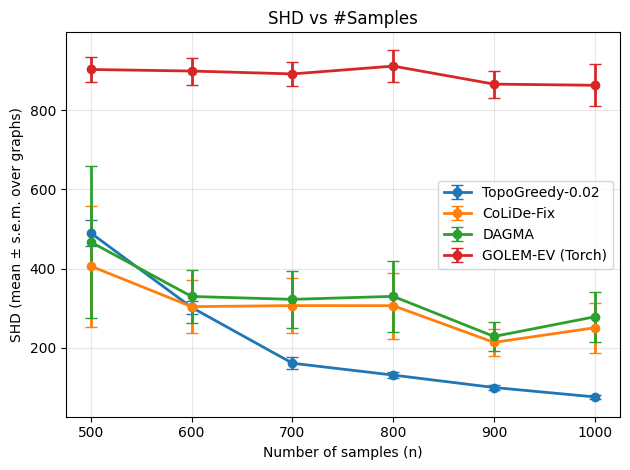

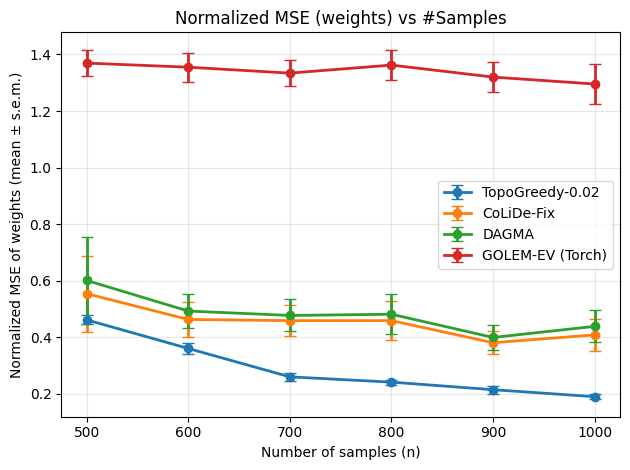

In [17]:
# ---------------------------------------------
# Example: configure and run (10 trials; multi n)
# ---------------------------------------------

# Make sure you have _to_jsonable somewhere to avoid a NameError in _save_manifest
try:
    _to_jsonable
except NameError:
    def _to_jsonable(x):
        try:
            json.dumps(x)
            return x
        except Exception:
            if hasattr(x, "__name__"):  # functions/classes
                return f"{getattr(x, '__module__', '')}.{x.__name__}"
            return str(x)

# Baselines (unchanged from your list)
Exps = [
    BaselineSpec(
        model=TopoGreedy_refresh,
        args={"k_list": [202], "threshold_list": [1e-4], "topo_thr": 0.5, "refresh_every": 0.02},
        name="TopoGreedy-0.02",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False,
        is_topogreedy_refresh=True
    ),
    BaselineSpec(
        model=colide_ev,
        init={},
        args={"lambda1": 0.05, "T": 4, "s": [1.0, 0.9, 0.8, 0.7],
              "warm_iter": 2e4, "max_iter": 7e4, "lr": 3e-4,
              "disable_tqdm": True},
        name="CoLiDe-Fix",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False
    ),
    BaselineSpec(
        model=DAGMA_linear,
        init={"loss_type": "l2"},
        args={"lambda1": 0.05, "T": 4, "s": [1.0, 0.9, 0.8, 0.8],
              "warm_iter": 2e4, "max_iter": 7e4, "lr": 3e-4,
              "disable_tqdm": True},
        name="DAGMA",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False
    ),
    BaselineSpec(
        model=GOLEM_Torch,
        init={
            "equal_variances": True,
            "lambda1": 2e-2,
            "lambda2": 5.0,
            "seed": 1,
            "verbose": False,
        },
        args={
            "lr": 1e-3,
            "max_iter": int(6e4),
            "tol": 1e-7,
            "print_every": 2000,
            "grad_clip": None,
        },
        name="GOLEM-EV (Torch)",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False
    ),
    # Example NOTEARS (optional)
    # BaselineSpec(
    #     model=notears_linear,
    #     args={"lambda1": 0.1},
    #     name="NOTEARS",
    #     standardize=True,
    #     adapt_lambda=True,
    #     topo_transpose=False
    # ),
]

# Data generation parameters (unchanged, but you can alter)
data_p = {
    "n_nodes": 200,
    "graph_type": "er",
    "edges": 4 * 200,
    "edge_type": "positive",
    "w_range": (0.5, 2.0),
    "var": 1.0,
    # "standarize": True,  # if you want to standardize data before emp_cov
}

# IMPORTANT: multiple sample sizes + 10 trials
cfg = ExperimentConfig(
    n_graphs=10,                                 # mean over 10 trials
    n_nodes=data_p["n_nodes"],
    n_samples_list=[500, 600, 700, 800, 900, 1000], # choose what you like
    edge_threshold=0.5,
    data_params=data_p,
    baselines=Exps,
    out_dir="./exp_results",
    run_tag=None,
    save_intermediate=True,
    seed_offset=0
)

# --- Run & Plot ---
runner = ExperimentRunner(cfg)
t0 = perf_counter()
final = runner.run(verbose=True)
t1 = perf_counter()
print(f"\n----- Completed in {(t1 - t0)/60:.3f} minutes -----")

# Create the two plots and save them next to final_results.npz
plot_summary_curves(final, cfg, runner.out_root, cfg.baselines)


In [29]:
import re

def _sanitize_baseline_name_for_csv(name: str) -> str:
    """Turn 'TopoGreedy-0.02' -> 'TopoGreedy_0_02' (safe CSV column header)."""
    return re.sub(r'[^A-Za-z0-9]+', '_', name).strip('_')

def save_summary_csvs(final: Dict[str, np.ndarray],
                      cfg: ExperimentConfig,
                      out_dir: Path,
                      baselines: List[BaselineSpec]) -> Tuple[Path, Path, Path]:
    """
    Writes three CSVs into out_dir:
      - shd_vs_samples.csv:   n_samples + (mean, sem, p10, p90) per baseline
      - nmse_vs_samples.csv:  n_samples + (mean, sem, p10, p90) per baseline
      - summary_vs_samples.csv: wide table with both metrics interleaved
    Returns the three paths.
    """
    import csv
    n_samples = np.asarray(cfg.n_samples_list)
    G = int(final["shd"].shape[0])
    B = int(final["shd"].shape[2])

    # Means, SEM, and percentiles across graphs
    def _sem(arr):
        return (arr.std(axis=0, ddof=1) / np.sqrt(G)) if G > 1 else np.zeros_like(arr.mean(axis=0))

    shd_mean = final["shd"].mean(axis=0)   # (S,B)
    shd_sem  = _sem(final["shd"])          # (S,B)
    shd_p10  = np.percentile(final["shd"], 10, axis=0)  # (S,B)
    shd_p90  = np.percentile(final["shd"], 90, axis=0)  # (S,B)
    
    nmse_mean = final["err"].mean(axis=0)  # (S,B) normalized MSE of weights
    nmse_sem  = _sem(final["err"])         # (S,B)
    nmse_p10  = np.percentile(final["err"], 10, axis=0)  # (S,B)
    nmse_p90  = np.percentile(final["err"], 90, axis=0)  # (S,B)

    # Make header labels safe for CSV/pgfplots
    safe_names = [_sanitize_baseline_name_for_csv(b.name) for b in baselines]
    orig_names = [b.name for b in baselines]  # for reference/legends

    # 1) SHD CSV
    shd_csv = out_dir / "shd_vs_samples.csv"
    with open(shd_csv, "w", newline="") as f:
        w = csv.writer(f)
        header = ["n_samples"]
        for sn in safe_names:
            header += [f"{sn}_mean", f"{sn}_sem", f"{sn}_p10", f"{sn}_p90"]
        w.writerow(header)
        for si, n in enumerate(n_samples):
            row = [int(n)]
            for bi in range(B):
                row += [float(shd_mean[si, bi]), float(shd_sem[si, bi]),
                        float(shd_p10[si, bi]), float(shd_p90[si, bi])]
            w.writerow(row)

    # 2) NMSE CSV
    nmse_csv = out_dir / "nmse_vs_samples.csv"
    with open(nmse_csv, "w", newline="") as f:
        w = csv.writer(f)
        header = ["n_samples"]
        for sn in safe_names:
            header += [f"{sn}_mean", f"{sn}_sem", f"{sn}_p10", f"{sn}_p90"]
        w.writerow(header)
        for si, n in enumerate(n_samples):
            row = [int(n)]
            for bi in range(B):
                row += [float(nmse_mean[si, bi]), float(nmse_sem[si, bi]),
                        float(nmse_p10[si, bi]), float(nmse_p90[si, bi])]
            w.writerow(row)

    # 3) Wide summary CSV (both metrics interleaved)
    summary_csv = out_dir / "summary_vs_samples.csv"
    with open(summary_csv, "w", newline="") as f:
        w = csv.writer(f)
        header = ["n_samples"]
        for sn in safe_names:
            header += [f"{sn}_SHD_mean", f"{sn}_SHD_sem", f"{sn}_SHD_p10", f"{sn}_SHD_p90",
                       f"{sn}_NMSE_mean", f"{sn}_NMSE_sem", f"{sn}_NMSE_p10", f"{sn}_NMSE_p90"]
        w.writerow(header)
        for si, n in enumerate(n_samples):
            row = [int(n)]
            for bi in range(B):
                row += [float(shd_mean[si, bi]),  float(shd_sem[si, bi]),
                        float(shd_p10[si, bi]),   float(shd_p90[si, bi]),
                        float(nmse_mean[si, bi]), float(nmse_sem[si, bi]),
                        float(nmse_p10[si, bi]),  float(nmse_p90[si, bi])]
            w.writerow(row)

    print("Saved CSVs:", shd_csv, nmse_csv, summary_csv, sep="\n- ")
    return shd_csv, nmse_csv, summary_csv



=== Graph 1/10 ===
- samples=500, edges≈782
  · TopoGreedy-0.02    | SHD 371.0 | F1 0.800 | ΘΔ 0.506 | 266.71s
  · TopoGreedy-0.04    | SHD 607.0 | F1 0.701 | ΘΔ 0.506 | 144.54s
  · CoLiDe-Fix         | SHD 128.0 | F1 0.913 | ΘΔ 0.000 | 135.88s
  · DAGMA              | SHD 132.0 | F1 0.910 | ΘΔ 0.000 | 118.12s
- samples=600, edges≈796
  · TopoGreedy-0.02    | SHD 353.0 | F1 0.810 | ΘΔ 0.445 | 260.68s
  · TopoGreedy-0.04    | SHD 525.0 | F1 0.737 | ΘΔ 0.445 | 138.81s
  · CoLiDe-Fix         | SHD 275.0 | F1 0.818 | ΘΔ 0.000 | 137.04s
  · DAGMA              | SHD 277.0 | F1 0.816 | ΘΔ 0.000 | 114.69s
- samples=700, edges≈808
  · TopoGreedy-0.02    | SHD 138.0 | F1 0.919 | ΘΔ 0.390 | 288.72s
  · TopoGreedy-0.04    | SHD 243.0 | F1 0.864 | ΘΔ 0.390 | 150.72s
  · CoLiDe-Fix         | SHD 231.0 | F1 0.849 | ΘΔ 0.000 | 143.08s
  · DAGMA              | SHD 218.0 | F1 0.857 | ΘΔ 0.000 | 113.34s
- samples=800, edges≈745
  · TopoGreedy-0.02    | SHD 106.0 | F1 0.932 | ΘΔ 0.369 | 332.28s
  · TopoG

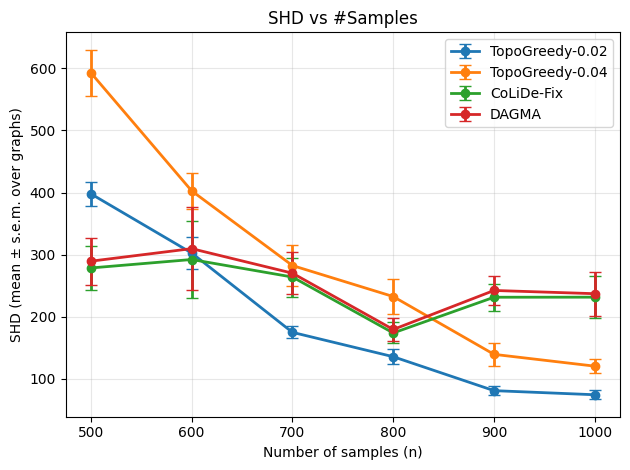

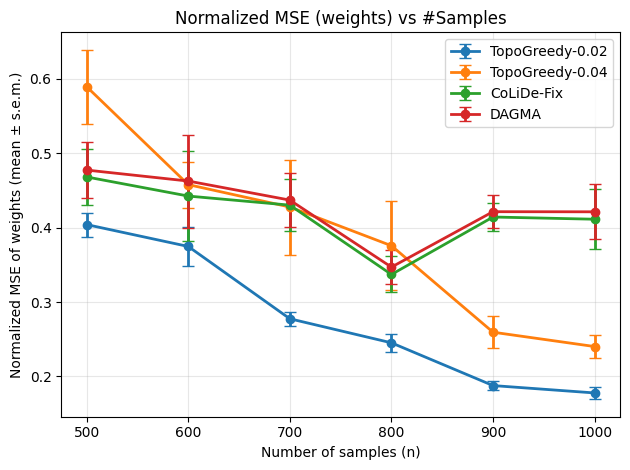

In [25]:

# ---------------------------------------------
# Example: configure and run (10 trials; multi n)
# ---------------------------------------------

# Make sure you have _to_jsonable somewhere to avoid a NameError in _save_manifest
try:
    _to_jsonable
except NameError:
    def _to_jsonable(x):
        try:
            json.dumps(x)
            return x
        except Exception:
            if hasattr(x, "__name__"):  # functions/classes
                return f"{getattr(x, '__module__', '')}.{x.__name__}"
            return str(x)

# Baselines (unchanged from your list)
Exps = [
    BaselineSpec(
        model=TopoGreedy_refresh,
        args={"k_list": [202], "threshold_list": [1e-4], "topo_thr": 0.5, "refresh_every": 0.02},
        name="TopoGreedy-0.02",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False,
        is_topogreedy_refresh=True
    ),
    BaselineSpec(
        model=TopoGreedy_refresh,
        args={"k_list": [202], "threshold_list": [1e-4], "topo_thr": 0.5, "refresh_every": 0.04},
        name="TopoGreedy-0.04",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False,
        is_topogreedy_refresh=True
    ),

    BaselineSpec(
        model=colide_ev,
        init={},
        args={"lambda1": 0.05, "T": 4, "s": [1.0, 0.9, 0.8, 0.7],
              "warm_iter": 2e4, "max_iter": 7e4, "lr": 3e-4,
              "disable_tqdm": True},
        name="CoLiDe-Fix",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False
    ),
    
    BaselineSpec(
        model=DAGMA_linear,
        init={"loss_type": "l2"},
        args={"lambda1": 0.05, "T": 4, "s": [1.0, 0.9, 0.8, 0.7],
              "warm_iter": 2e4, "max_iter": 7e4, "lr": 3e-4,
              "disable_tqdm": True},
        name="DAGMA",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False
    ),
    # BaselineSpec(
    #     model=GOLEM_Torch,
    #     init={
    #         "equal_variances": True,
    #         "lambda1": 2e-2,
    #         "lambda2": 5.0,
    #         "seed": 1,
    #         "verbose": False,
    #     },
    #     args={
    #         "lr": 1e-3,
    #         "max_iter": int(6e4),
    #         "tol": 1e-7,
    #         "print_every": 2000,
    #         "grad_clip": None,
    #     },
    #     name="GOLEM-EV (Torch)",
    #     standardize=False,
    #     adapt_lambda=False,
    #     topo_transpose=False
    # ),
    # Example NOTEARS (optional)
    # BaselineSpec(
    #     model=notears_linear,
    #     args={"lambda1": 0.1},
    #     name="NOTEARS",
    #     standardize=True,
    #     adapt_lambda=True,
    #     topo_transpose=False
    # ),
]

# Data generation parameters (unchanged, but you can alter)
data_p = {
    "n_nodes": 200,
    "graph_type": "er",
    "edges": 4 * 200,
    "edge_type": "positive",
    "w_range": (0.5, 2.0),
    "var": 1.0,
    # "standarize": True,  # if you want to standardize data before emp_cov
}

# IMPORTANT: multiple sample sizes + 10 trials
cfg = ExperimentConfig(
    n_graphs=10,                                 # mean over 10 trials
    n_nodes=data_p["n_nodes"],
    n_samples_list=[500, 600, 700, 800, 900, 1000], # choose what you like
    edge_threshold=0.5,
    data_params=data_p,
    baselines=Exps,
    out_dir="./exp_results",
    run_tag=None,
    save_intermediate=True,
    seed_offset=0
)

# --- Run & Plot ---
runner = ExperimentRunner(cfg)
t0 = perf_counter()
final = runner.run(verbose=True)
t1 = perf_counter()
print(f"\n----- Completed in {(t1 - t0)/60:.3f} minutes -----")

# Create the two plots and save them next to final_results.npz
plot_summary_curves(final, cfg, runner.out_root, cfg.baselines)
# Save CSVs for Overleaf
shd_csv, nmse_csv, summary_csv = save_summary_csvs(final, cfg, runner.out_root, cfg.baselines)




=== Graph 1/10 ===
- samples=500, edges≈773
  · TopoGreedy-0.02    | SHD 447.0 | F1 0.764 | ΘΔ 0.541 | 253.82s
  · TopoGreedy-0.04    | SHD 454.0 | F1 0.761 | ΘΔ 0.541 | 125.54s
  · CoLiDe-Fix         | SHD 81.0 | F1 0.945 | ΘΔ 0.000 | 80.76s
  · DAGMA              | SHD 107.0 | F1 0.927 | ΘΔ 0.000 | 80.52s
- samples=600, edges≈810
  · TopoGreedy-0.02    | SHD 257.0 | F1 0.858 | ΘΔ 0.451 | 265.12s
  · TopoGreedy-0.04    | SHD 337.0 | F1 0.818 | ΘΔ 0.451 | 138.11s
  · CoLiDe-Fix         | SHD 236.0 | F1 0.844 | ΘΔ 0.000 | 130.07s
  · DAGMA              | SHD 250.0 | F1 0.833 | ΘΔ 0.000 | 114.08s
- samples=700, edges≈887
  · TopoGreedy-0.02    | SHD 232.0 | F1 0.881 | ΘΔ 0.391 | 279.55s
  · TopoGreedy-0.04    | SHD 333.0 | F1 0.837 | ΘΔ 0.391 | 142.57s
  · CoLiDe-Fix         | SHD 91.0 | F1 0.946 | ΘΔ 0.000 | 94.90s
  · DAGMA              | SHD 77.0 | F1 0.955 | ΘΔ 0.000 | 68.26s
- samples=800, edges≈764
  · TopoGreedy-0.02    | SHD 109.0 | F1 0.931 | ΘΔ 0.361 | 297.15s
  · TopoGreedy-0

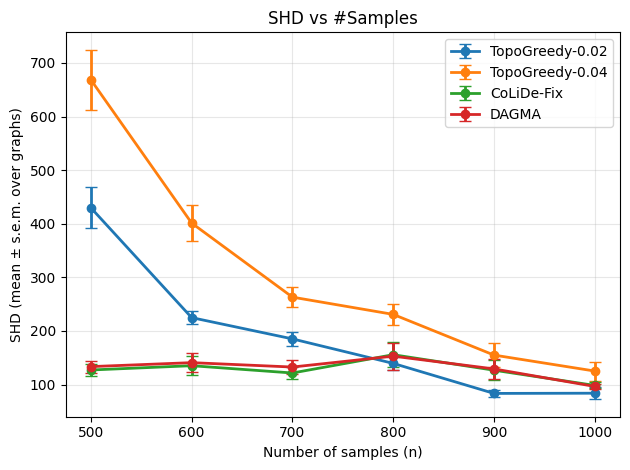

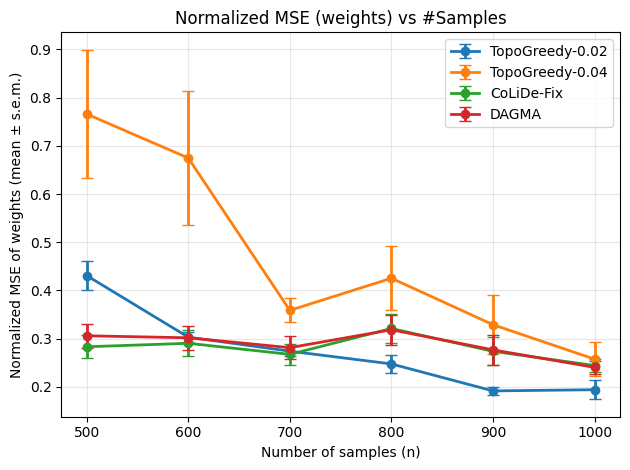

In [27]:

# ---------------------------------------------
# Example: configure and run (10 trials; multi n)
# ---------------------------------------------

# Make sure you have _to_jsonable somewhere to avoid a NameError in _save_manifest
try:
    _to_jsonable
except NameError:
    def _to_jsonable(x):
        try:
            json.dumps(x)
            return x
        except Exception:
            if hasattr(x, "__name__"):  # functions/classes
                return f"{getattr(x, '__module__', '')}.{x.__name__}"
            return str(x)

# Baselines (unchanged from your list)
Exps = [
    BaselineSpec(
        model=TopoGreedy_refresh,
        args={"k_list": [202], "threshold_list": [1e-4], "topo_thr": 0.5, "refresh_every": 0.02},
        name="TopoGreedy-0.02",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False,
        is_topogreedy_refresh=True
    ),
    BaselineSpec(
        model=TopoGreedy_refresh,
        args={"k_list": [202], "threshold_list": [1e-4], "topo_thr": 0.5, "refresh_every": 0.04},
        name="TopoGreedy-0.04",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False,
        is_topogreedy_refresh=True
    ),

    BaselineSpec(
        model=colide_ev,
        init={},
        args={"lambda1": 0.05, "T": 4, "s": [1.0, 0.9, 0.8, 0.7],
              "warm_iter": 2e4, "max_iter": 7e4, "lr": 3e-4,
              "disable_tqdm": True},
        name="CoLiDe-Fix",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False
    ),
    
    BaselineSpec(
        model=DAGMA_linear,
        init={"loss_type": "l2"},
        args={"lambda1": 0.05, "T": 4, "s": [1.0, 0.9, 0.8, 0.7],
              "warm_iter": 2e4, "max_iter": 7e4, "lr": 3e-4,
              "disable_tqdm": True},
        name="DAGMA",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False
    ),
    # BaselineSpec(
    #     model=GOLEM_Torch,
    #     init={
    #         "equal_variances": True,
    #         "lambda1": 2e-2,
    #         "lambda2": 5.0,
    #         "seed": 1,
    #         "verbose": False,
    #     },
    #     args={
    #         "lr": 1e-3,
    #         "max_iter": int(6e4),
    #         "tol": 1e-7,
    #         "print_every": 2000,
    #         "grad_clip": None,
    #     },
    #     name="GOLEM-EV (Torch)",
    #     standardize=False,
    #     adapt_lambda=False,
    #     topo_transpose=False
    # ),
    # Example NOTEARS (optional)
    # BaselineSpec(
    #     model=notears_linear,
    #     args={"lambda1": 0.1},
    #     name="NOTEARS",
    #     standardize=True,
    #     adapt_lambda=True,
    #     topo_transpose=False
    # ),
]

# Data generation parameters (unchanged, but you can alter)
data_p = {
    "n_nodes": 200,
    "graph_type": "er",
    "edges": 4 * 200,
    "edge_type": "weighted",
    "w_range": ((-2.0, -0.5), (0.5, 2.0)),
    "var": 1.0,
    # "standarize": True,  # if you want to standardize data before emp_cov
}

# IMPORTANT: multiple sample sizes + 10 trials
cfg = ExperimentConfig(
    n_graphs=10,                                 # mean over 10 trials
    n_nodes=data_p["n_nodes"],
    n_samples_list=[500, 600, 700, 800, 900, 1000], # choose what you like
    edge_threshold=0.5,
    data_params=data_p,
    baselines=Exps,
    out_dir="./exp_results",
    run_tag=None,
    save_intermediate=True,
    seed_offset=0
)

# --- Run & Plot ---
runner = ExperimentRunner(cfg)
t0 = perf_counter()
final = runner.run(verbose=True)
t1 = perf_counter()
print(f"\n----- Completed in {(t1 - t0)/60:.3f} minutes -----")

# Create the two plots and save them next to final_results.npz
plot_summary_curves(final, cfg, runner.out_root, cfg.baselines)
# Save CSVs for Overleaf
shd_csv, nmse_csv, summary_csv = save_summary_csvs(final, cfg, runner.out_root, cfg.baselines)




=== Graph 1/10 ===
- samples=500, edges≈773
  · TopoGreedy-0.04    | SHD 860.0 | F1 0.626 | ΘΔ 0.527 | 137.04s
  · TopoGreedy-0.02    | SHD 545.0 | F1 0.729 | ΘΔ 0.527 | 250.48s
  · CoLiDe-Fix         | SHD 149.0 | F1 0.897 | ΘΔ 0.000 | 130.59s
  · DAGMA              | SHD 128.0 | F1 0.912 | ΘΔ 0.000 | 112.86s
- samples=600, edges≈831
  · TopoGreedy-0.04    | SHD 462.0 | F1 0.769 | ΘΔ 0.448 | 135.73s
  · TopoGreedy-0.02    | SHD 204.0 | F1 0.888 | ΘΔ 0.448 | 263.15s
  · CoLiDe-Fix         | SHD 162.0 | F1 0.897 | ΘΔ 0.000 | 129.62s
  · DAGMA              | SHD 161.0 | F1 0.896 | ΘΔ 0.000 | 112.85s
- samples=700, edges≈754
  · TopoGreedy-0.04    | SHD 385.0 | F1 0.782 | ΘΔ 0.407 | 145.22s
  · TopoGreedy-0.02    | SHD 177.0 | F1 0.890 | ΘΔ 0.407 | 267.89s
  · CoLiDe-Fix         | SHD 75.0 | F1 0.947 | ΘΔ 0.000 | 63.22s
  · DAGMA              | SHD 76.0 | F1 0.946 | ΘΔ 0.000 | 53.40s
- samples=800, edges≈777
  · TopoGreedy-0.04    | SHD 212.0 | F1 0.877 | ΘΔ 0.360 | 150.37s
  · TopoGreed

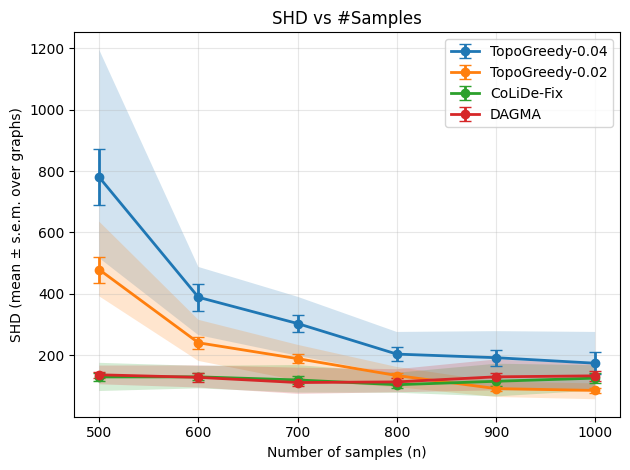

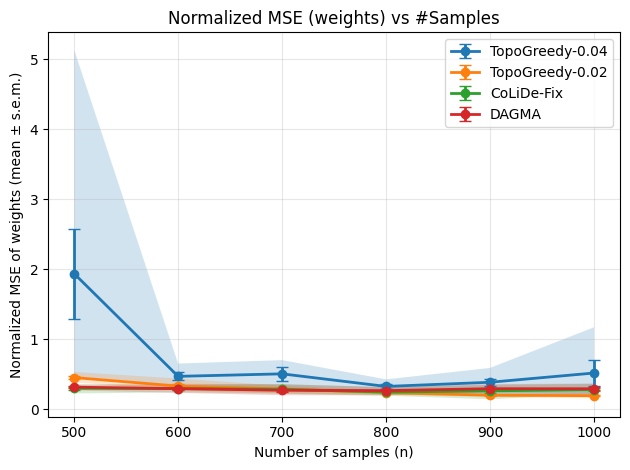

In [39]:

# ---------------------------------------------
# Example: configure and run (10 trials; multi n)
# ---------------------------------------------

# Make sure you have _to_jsonable somewhere to avoid a NameError in _save_manifest
try:
    _to_jsonable
except NameError:
    def _to_jsonable(x):
        try:
            json.dumps(x)
            return x
        except Exception:
            if hasattr(x, "__name__"):  # functions/classes
                return f"{getattr(x, '__module__', '')}.{x.__name__}"
            return str(x)

# Baselines (unchanged from your list)
Exps = [
    BaselineSpec(
        model=TopoGreedy_refresh,
        args={"k_list": [202], "threshold_list": [1e-4], "topo_thr": 0.5, "refresh_every": 0.04},
        name="TopoGreedy-0.04",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False,
        is_topogreedy_refresh=True
    ),
    BaselineSpec(
        model=TopoGreedy_refresh,
        args={"k_list": [202], "threshold_list": [1e-4], "topo_thr": 0.5, "refresh_every": 0.02},
        name="TopoGreedy-0.02",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False,
        is_topogreedy_refresh=True
    ),

    BaselineSpec(
        model=colide_ev,
        init={},
        args={"lambda1": 0.05, "T": 4, "s": [1.0, 0.9, 0.8, 0.7],
              "warm_iter": 2e4, "max_iter": 7e4, "lr": 3e-4,
              "disable_tqdm": True},
        name="CoLiDe-Fix",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False
    ),
    
    BaselineSpec(
        model=DAGMA_linear,
        init={"loss_type": "l2"},
        args={"lambda1": 0.05, "T": 4, "s": [1.0, 0.9, 0.8, 0.7],
              "warm_iter": 2e4, "max_iter": 7e4, "lr": 3e-4,
              "disable_tqdm": True},
        name="DAGMA",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False
    ),
    # BaselineSpec(
    #     model=GOLEM_Torch,
    #     init={
    #         "equal_variances": True,
    #         "lambda1": 2e-2,
    #         "lambda2": 5.0,
    #         "seed": 1,
    #         "verbose": False,
    #     },
    #     args={
    #         "lr": 1e-3,
    #         "max_iter": int(6e4),
    #         "tol": 1e-7,
    #         "print_every": 2000,
    #         "grad_clip": None,
    #     },
    #     name="GOLEM-EV (Torch)",
    #     standardize=False,
    #     adapt_lambda=False,
    #     topo_transpose=False
    # ),
    # Example NOTEARS (optional)
    # BaselineSpec(
    #     model=notears_linear,
    #     args={"lambda1": 0.1},
    #     name="NOTEARS",
    #     standardize=True,
    #     adapt_lambda=True,
    #     topo_transpose=False
    # ),
]

# Data generation parameters (unchanged, but you can alter)
data_p = {
    "n_nodes": 200,
    "graph_type": "er",
    "edges": 4 * 200,
    "edge_type": "weighted",
    "w_range": ((-2.0, -0.5), (0.5, 2.0)),
    "var": 1.0,
    # "standarize": True,  # if you want to standardize data before emp_cov
}

# IMPORTANT: multiple sample sizes + 10 trials
cfg = ExperimentConfig(
    n_graphs=10,                                 # mean over 10 trials
    n_nodes=data_p["n_nodes"],
    n_samples_list=[500, 600, 700, 800, 900, 1000], # choose what you like
    edge_threshold=0.5,
    data_params=data_p,
    baselines=Exps,
    out_dir="./exp_results",
    run_tag=None,
    save_intermediate=True,
    seed_offset=0
)

# --- Run & Plot ---
runner = ExperimentRunner(cfg)
t0 = perf_counter()
final = runner.run(verbose=True)
t1 = perf_counter()
print(f"\n----- Completed in {(t1 - t0)/60:.3f} minutes -----")

# Create the two plots and save them next to final_results.npz
plot_summary_curves(final, cfg, runner.out_root, cfg.baselines)
# Save CSVs for Overleaf
shd_csv, nmse_csv, summary_csv = save_summary_csvs(final, cfg, runner.out_root, cfg.baselines)



In [16]:
Exps = [
    BaselineSpec(
        model=TopoGreedy_refresh,
        args={"k_list": [202], "threshold_list": [1e-4], "topo_thr": 0.5, "refresh_every": 0.04},
        name="TopoGreedy-0.04",
        standardize=False,     # set True if you want standardized X
        adapt_lambda=False,
        topo_transpose=False,  # flip if your downstream expects transpose
        is_topogreedy_refresh=True
    ),
    BaselineSpec(
        model=TopoGreedy_refresh,
        args={"k_list": [202], "threshold_list": [1e-4], "topo_thr": 0.5, "refresh_every": 0.02},
        name="TopoGreedy-0.02",
        standardize=False,     # set True if you want standardized X
        adapt_lambda=False,
        topo_transpose=False,  # flip if your downstream expects transpose
        is_topogreedy_refresh=True
    ),

    BaselineSpec(
        model=TopoGreedy_refresh,
        args={"k_list": [202], "threshold_list": [1e-4], "topo_thr": 0.5, "refresh_every": 0.005},
        name="TopoGreedy-0.005",
        standardize=False,     # set True if you want standardized X
        adapt_lambda=False,
        topo_transpose=False,  # flip if your downstream expects transpose
        is_topogreedy_refresh=True
    ),
    BaselineSpec(
        model=colide_ev,
        init={},  # uses default dtype/seed; adjust as needed
        args={"lambda1": 0.05, "T": 4, "s": [1.0, 0.9, 0.8, 0.7],
              "warm_iter": 2e4, "max_iter": 7e4, "lr": 3e-4,
              "disable_tqdm": True},
        name="CoLiDe-Fix",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False
    ),
    BaselineSpec(
        model=DAGMA_linear,
        init={"loss_type": "l2"},
        args={"lambda1": 0.05, "T": 4, "s": [1.0, 0.9, 0.8, 0.8],
              "warm_iter": 2e4, "max_iter": 7e4, "lr": 3e-4,
              "disable_tqdm": True},
        name="DAGMA",
        standardize=False,
        adapt_lambda=False,
        topo_transpose=False
    ),
]
data_p = {
    "n_nodes": 200,
    "graph_type": "er",
    "edges": 4 * 200,
    "edge_type": "weighted",
    "w_range": ((-2.0, -0.5), (0.5, 2.0)),
    "var": 1.0,
}

cfg = ExperimentConfig(
    n_graphs=20,                       
    n_nodes=data_p["n_nodes"],
    n_samples_list=[1000],              
    edge_threshold=0.5,
    data_params=data_p,
    baselines=Exps,
    out_dir="./exp_results",
    run_tag=None,                      
    save_intermediate=True,
    seed_offset=0
)

runner = ExperimentRunner(cfg)
t0 = perf_counter()
final = runner.run(verbose=True)
t1 = perf_counter()
print(f"\n----- Completed in {(t1 - t0)/60:.3f} minutes -----")



=== Graph 1/20 ===
- samples=1000, edges≈794
  · TopoGreedy-0.04    | SHD 99.0 | F1 0.939 | ΘΔ 0.306 | 182.39s
  · TopoGreedy-0.02    | SHD 64.0 | F1 0.960 | ΘΔ 0.306 | 350.27s
  · TopoGreedy-0.005   | SHD 25.0 | F1 0.984 | ΘΔ 0.306 | 1395.84s
  · CoLiDe-Fix         | SHD 161.0 | F1 0.891 | ΘΔ 0.000 | 122.64s
  · DAGMA              | SHD 168.0 | F1 0.885 | ΘΔ 0.000 | 90.52s

=== Graph 2/20 ===
- samples=1000, edges≈815
  · TopoGreedy-0.04    | SHD 182.0 | F1 0.895 | ΘΔ 0.314 | 184.57s
  · TopoGreedy-0.02    | SHD 109.0 | F1 0.936 | ΘΔ 0.314 | 336.58s
  · TopoGreedy-0.005   | SHD 17.0 | F1 0.989 | ΘΔ 0.314 | 1289.23s
  · CoLiDe-Fix         | SHD 104.0 | F1 0.933 | ΘΔ 0.000 | 132.73s
  · DAGMA              | SHD 146.0 | F1 0.904 | ΘΔ 0.000 | 96.50s

=== Graph 3/20 ===
- samples=1000, edges≈762
  · TopoGreedy-0.04    | SHD 92.0 | F1 0.940 | ΘΔ 0.303 | 179.88s
  · TopoGreedy-0.02    | SHD 43.0 | F1 0.972 | ΘΔ 0.303 | 339.15s
  · TopoGreedy-0.005   | SHD 15.0 | F1 0.990 | ΘΔ 0.303 | 1272.7

In [9]:
import numpy as np
import pandas as pd

results_path = "exp_results/20250913_012501_25daf9/final_results.npz"
final = dict(np.load(results_path, allow_pickle=True))

# Assume Exps is available and contains the baseline names in order
baseline_names = [b.name for b in Exps]

# Compute means and stds over axis 0 (n_graphs)
shd_mean = final["shd"].mean(axis=0).squeeze()
shd_std = final["shd"].std(axis=0).squeeze()
fdr_mean = final["fdr"].mean(axis=0).squeeze()
fdr_std = final["fdr"].std(axis=0).squeeze()
tpr_mean = final["tpr"].mean(axis=0).squeeze()
tpr_std = final["tpr"].std(axis=0).squeeze()
f1_mean = final["f1"].mean(axis=0).squeeze()
f1_std = final["f1"].std(axis=0).squeeze()
runtime_mean = final["runtime"].mean(axis=0).squeeze()
runtime_std = final["runtime"].std(axis=0).squeeze()

# Format as "mean ± std" with 2 decimals
def fmt(m, s):
    return [f"{mean:.2f} ± {std:.2f}" for mean, std in zip(m, s)]

df = pd.DataFrame({
    "Baseline": baseline_names,
    "SHD": fmt(shd_mean, shd_std),
    "FDR": fmt(fdr_mean, fdr_std),
    "TPR": fmt(tpr_mean, tpr_std),
    "F1": fmt(f1_mean, f1_std),
    "Time (s)": fmt(runtime_mean, runtime_std)
})

# Display nicely as a table
from IPython.display import display, HTML
display(HTML(df.to_html(index=False, escape=False)))


Baseline,SHD,FDR,TPR,F1,Time (s)
TopoGreedy-0.02,91.90 ± 16.16,0.08 ± 0.02,0.97 ± 0.00,0.94 ± 0.01,334.72 ± 17.56
TopoGreedy-0.04,148.05 ± 41.47,0.14 ± 0.04,0.97 ± 0.01,0.91 ± 0.02,180.16 ± 7.95
TopoGreedy-0.005,21.35 ± 5.05,0.01 ± 0.00,0.98 ± 0.01,0.99 ± 0.00,1271.90 ± 57.80
TopoGreedy-0.02-no-diag,91.90 ± 16.16,0.08 ± 0.02,0.97 ± 0.00,0.94 ± 0.01,342.51 ± 15.31
CoLiDe-Fix,125.35 ± 63.08,0.04 ± 0.04,0.88 ± 0.04,0.92 ± 0.04,100.93 ± 20.41
DAGMA,144.45 ± 63.00,0.04 ± 0.04,0.85 ± 0.04,0.90 ± 0.04,88.29 ± 16.89


In [19]:
# Convert the npz results to CSV format suitable for LaTeX/Overleaf
import os

# Create a LaTeX-friendly summary table
summary_data = []
for b, baseline in enumerate(baseline_names):
    # Format numbers for LaTeX with proper precision
    summary_row = {
        'Baseline': baseline.replace('_', '\\_'),  # Escape underscores for LaTeX
        'SHD': f"{shd_mean[b]:.2f} $\\pm$ {shd_std[b]:.2f}",
        'FDR': f"{fdr_mean[b]:.3f} $\\pm$ {fdr_std[b]:.3f}",
        'TPR': f"{tpr_mean[b]:.3f} $\\pm$ {tpr_std[b]:.3f}",
        'F1': f"{f1_mean[b]:.3f} $\\pm$ {f1_std[b]:.3f}",
        'Time (s)': f"{runtime_mean[b]:.2f} $\\pm$ {runtime_std[b]:.2f}"
    }
    summary_data.append(summary_row)

# Create DataFrame for LaTeX table
latex_df = pd.DataFrame(summary_data)

# Save LaTeX-friendly CSV
latex_csv_path = results_path.replace('.npz', '_latex.csv')
latex_df.to_csv(latex_csv_path, index=False)
print(f"LaTeX-friendly results saved to: {latex_csv_path}")

# Also create a raw data CSV with separate mean/std columns for more flexibility
raw_summary_data = []
for b, baseline in enumerate(baseline_names):
    raw_row = {
        'baseline': baseline,
        'shd_mean': f"{shd_mean[b]:.2f}",
        'shd_std': f"{shd_std[b]:.2f}",
        'fdr_mean': f"{fdr_mean[b]:.3f}",
        'fdr_std': f"{fdr_std[b]:.3f}",
        'tpr_mean': f"{tpr_mean[b]:.3f}",
        'tpr_std': f"{tpr_std[b]:.3f}",
        'f1_mean': f"{f1_mean[b]:.3f}",
        'f1_std': f"{f1_std[b]:.3f}",
        'runtime_mean': f"{runtime_mean[b]:.2f}",
        'runtime_std': f"{runtime_std[b]:.2f}"
    }
    raw_summary_data.append(raw_row)

raw_df = pd.DataFrame(raw_summary_data)
raw_csv_path = results_path.replace('.npz', '_raw_summary.csv')
raw_df.to_csv(raw_csv_path, index=False)
print(f"Raw summary results saved to: {raw_csv_path}")

# Display the LaTeX-ready table
print("\nLaTeX-ready table:")
print(latex_df.to_string(index=False))



LaTeX-friendly results saved to: exp_results/20250911_005145_d00ecf/final_results_latex.csv
Raw summary results saved to: exp_results/20250911_005145_d00ecf/final_results_raw_summary.csv

LaTeX-ready table:
        Baseline                SHD               FDR               TPR                F1            Time (s)
 TopoGreedy-0.04 130.90 $\pm$ 45.58 0.121 $\pm$ 0.040 0.970 $\pm$ 0.006 0.921 $\pm$ 0.024   171.75 $\pm$ 6.43
 TopoGreedy-0.02  75.30 $\pm$ 23.64 0.068 $\pm$ 0.024 0.977 $\pm$ 0.006 0.954 $\pm$ 0.013  328.74 $\pm$ 10.01
TopoGreedy-0.005   17.55 $\pm$ 4.42 0.003 $\pm$ 0.002 0.981 $\pm$ 0.005 0.989 $\pm$ 0.003 1239.60 $\pm$ 48.79
      CoLiDe-Fix 109.00 $\pm$ 28.89 0.030 $\pm$ 0.018 0.890 $\pm$ 0.025 0.928 $\pm$ 0.019  103.15 $\pm$ 21.19
           DAGMA 131.15 $\pm$ 29.95 0.031 $\pm$ 0.015 0.862 $\pm$ 0.028 0.912 $\pm$ 0.021   86.79 $\pm$ 19.19


In [12]:
Exps = [
    BaselineSpec(
        model=TopoGreedy_refresh,
        args={"k_list": [202], "threshold_list": [5e-4], "topo_thr": 0.5, "refresh_every": 0.005},
        name="TopoGreedy-0.02",
        standardize=False,     # set True if you want standardized X
        adapt_lambda=False,
        topo_transpose=False,  # flip if your downstream expects transpose
        is_topogreedy_refresh=True
    ),
    # BaselineSpec(
    #     model=colide_ev,
    #     init={},  # uses default dtype/seed; adjust as needed
    #     args={"lambda1": 0.05, "T": 4, "s": [1.0, 0.9, 0.8, 0.7],
    #           "warm_iter": 2e4, "max_iter": 7e4, "lr": 3e-4,
    #           "disable_tqdm": True},
    #     name="CoLiDe-Fix",
    #     standardize=False,
    #     adapt_lambda=False,
    #     topo_transpose=False
    # ),
    # BaselineSpec(
    #     model=DAGMA_linear,
    #     init={"loss_type": "l2"},
    #     args={"lambda1": 0.05, "T": 4, "s": [1.0, 0.9, 0.8, 0.8],
    #           "warm_iter": 2e4, "max_iter": 7e4, "lr": 3e-4,
    #           "disable_tqdm": True},
    #     name="DAGMA",
    #     standardize=False,
    #     adapt_lambda=False,
    #     topo_transpose=False
    # ),
    # BaselineSpec(
    #     model=GOLEM_Torch,
    #     init={  # constructor (static) hyperparams
    #         "equal_variances": True,     # EV; set False for NV
    #         "lambda1": 2e-2,             # per GOLEM-EV
    #         "lambda2": 5.0,
    #         "seed": 1,
    #         "verbose": False,
    #         # "B_init": some (d,d) numpy array if you want
    #     },
    #     args={  # training (per-fit) hyperparams
    #         "lr": 1e-3,
    #         "max_iter": int(6e4),
    #         "tol": 1e-7,
    #         "print_every": 2000,
    #         "grad_clip": None,
    #     },
    #     name="GOLEM-EV (Torch)",
    #     standardize=False,        # keep consistent with your other baselines
    #     adapt_lambda=False,       # GOLEM doesn't use lambda1 scaling by default
    #     topo_transpose=False
    # )
    # Example of adding NOTEARS (function-style)
    # BaselineSpec(
    #     model=notears_linear,
    #     args={"lambda1": 0.1},        # adjust
    #     name="NOTEARS",
    #     standardize=True,
    #     adapt_lambda=True,
    #     topo_transpose=False
    # ),
    # Add GOLEM baseline (GOLEM-EV as example)
]
# Data generation parameters (one place)
data_p = {
    "n_nodes": 200,
    "graph_type": "er",
    "edges": 4 * 200,
    "edge_type": "positive",
    "w_range": (0.5, 1.0),
    "var": 1.0,
    # "standarize": True,   # enable if you want data-standardization *before* emp_cov
    # verbose=True,
}

cfg = ExperimentConfig(
    n_graphs=1,                         # e.g., 8 * 10 trials
    n_nodes=data_p["n_nodes"],
    n_samples_list=[100],               # add more: [500, 1000, 2000, 5000]
    edge_threshold=0.5,
    data_params=data_p,
    baselines=Exps,
    out_dir="./exp_results",
    run_tag=None,                        # or a custom string
    save_intermediate=True,
    seed_offset=0,
    # verbose=True
)

# --- Run ---
runner = ExperimentRunner(cfg)
t0 = perf_counter()
final = runner.run(verbose=True)
t1 = perf_counter()
print(f"\n----- Completed in {(t1 - t0)/60:.3f} minutes -----")

# import numpy as np
# import pandas as pd

# results_path = "exp_results/20250824_174043_bb04df/final_results.npz"
# final = dict(np.load(results_path, allow_pickle=True))

# # Assume Exps is available and contains the baseline names in order
# baseline_names = [b.name for b in Exps]

# # Compute means and stds over axis 0 (n_graphs)
# shd_mean = final["shd"].mean(axis=0).squeeze()
# shd_std = final["shd"].std(axis=0).squeeze()
# fdr_mean = final["fdr"].mean(axis=0).squeeze()
# fdr_std = final["fdr"].std(axis=0).squeeze()
# tpr_mean = final["tpr"].mean(axis=0).squeeze()
# tpr_std = final["tpr"].std(axis=0).squeeze()
# f1_mean = final["f1"].mean(axis=0).squeeze()
# f1_std = final["f1"].std(axis=0).squeeze()
# runtime_mean = final["runtime"].mean(axis=0).squeeze()
# runtime_std = final["runtime"].std(axis=0).squeeze()

# # Format as "mean ± std" with 2 decimals
# def fmt(m, s):
#     return [f"{mean:.2f} ± {std:.2f}" for mean, std in zip(m, s)]

# df = pd.DataFrame({
#     "Baseline": baseline_names,
#     "SHD": fmt(shd_mean, shd_std),
#     "FDR": fmt(fdr_mean, fdr_std),
#     "TPR": fmt(tpr_mean, tpr_std),
#     "F1": fmt(f1_mean, f1_std),
#     "Time (s)": fmt(runtime_mean, runtime_std)
# })

# # Display nicely as a table
# from IPython.display import display, HTML
# display(HTML(df.to_html(index=False, escape=False)))




=== Graph 1/1 ===
- samples=100, edges≈836
[init] p=200, refresh_every=0.005 -> refresh at removals: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]

--- step 0 | remove le

KeyboardInterrupt: 

Run 1: SHD = 45


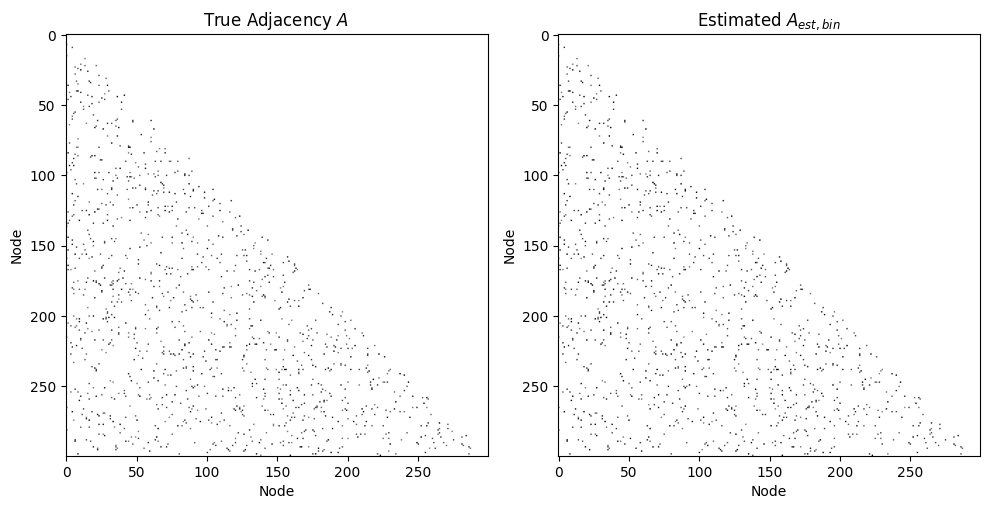

Run 2: SHD = 40


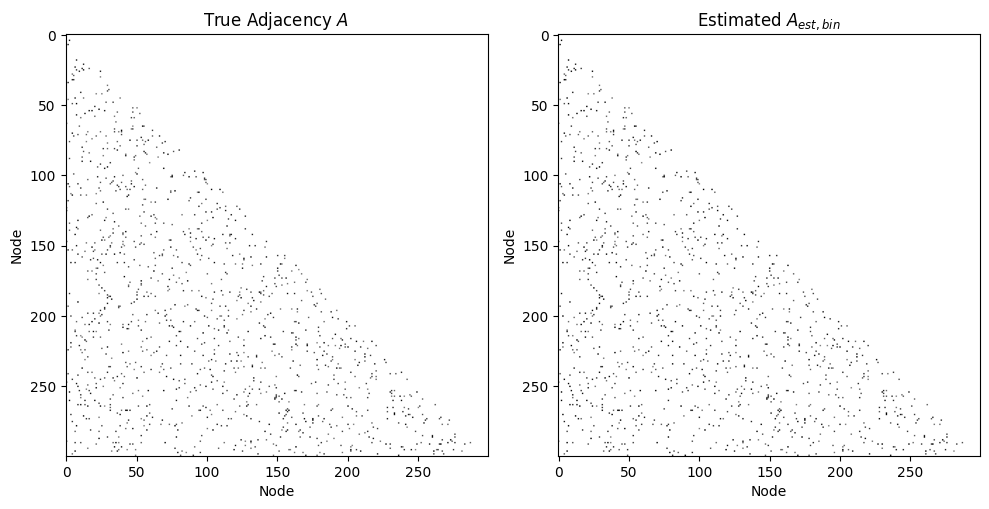

Run 3: SHD = 35


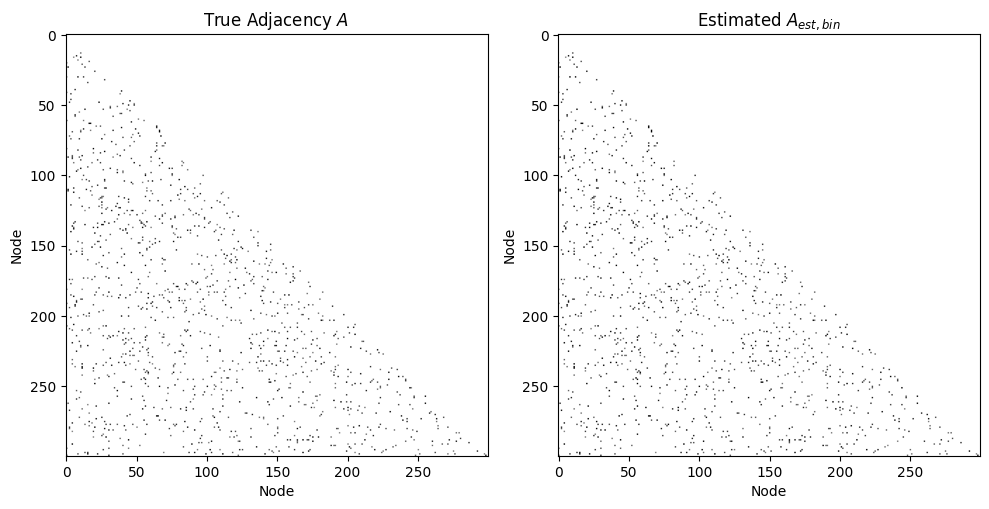

Run 4: SHD = 57


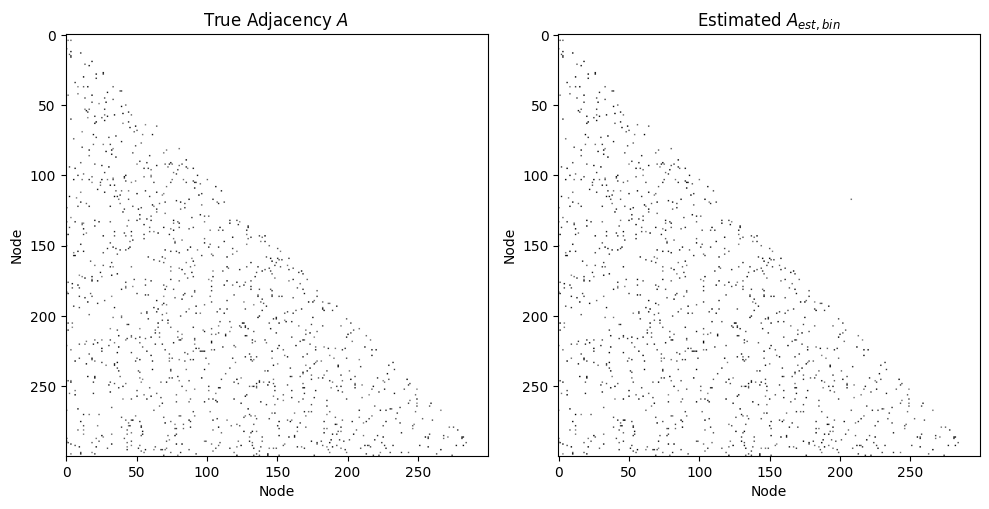

Run 5: SHD = 41


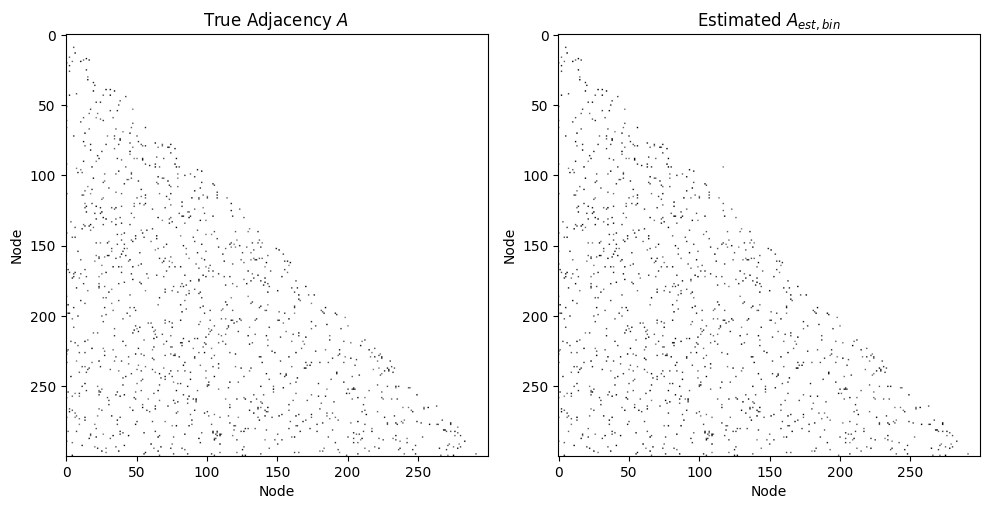

Run 6: SHD = 51


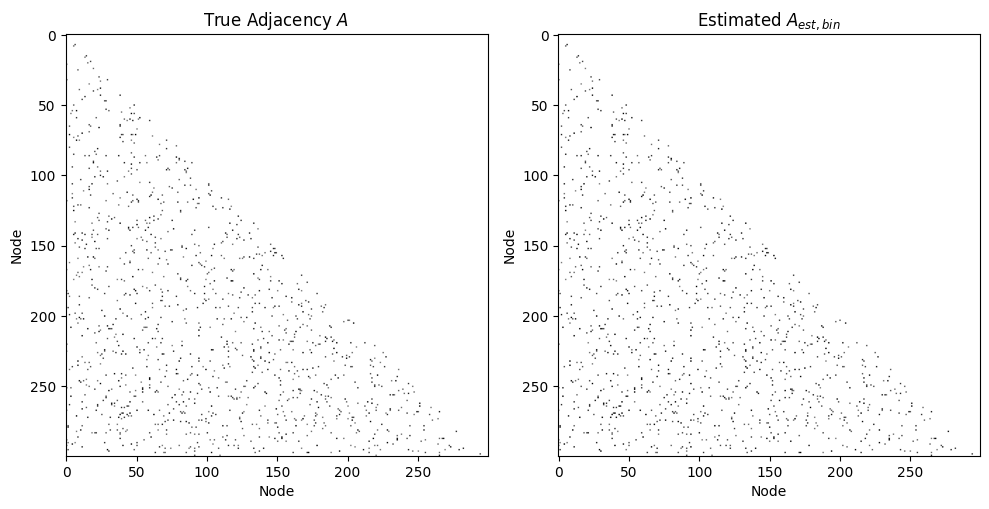

Run 7: SHD = 44


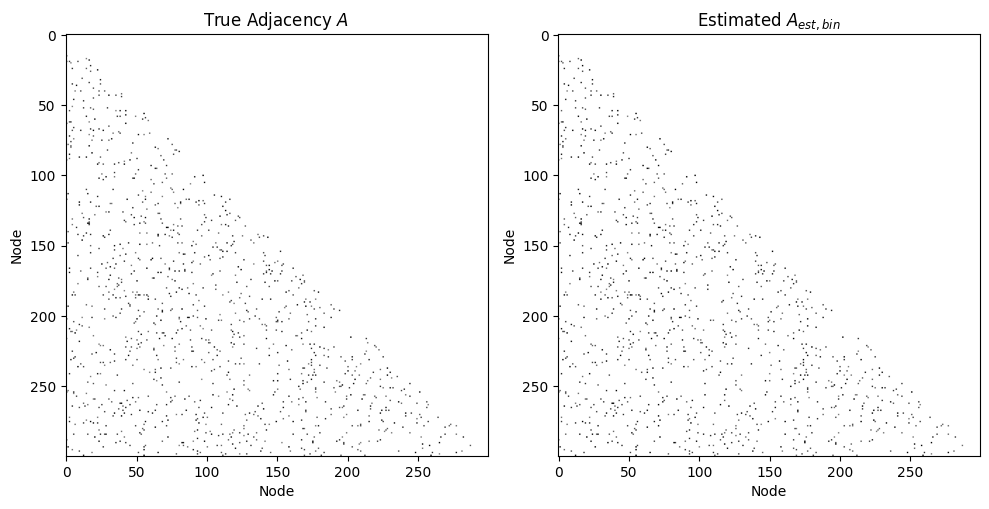

Run 8: SHD = 36


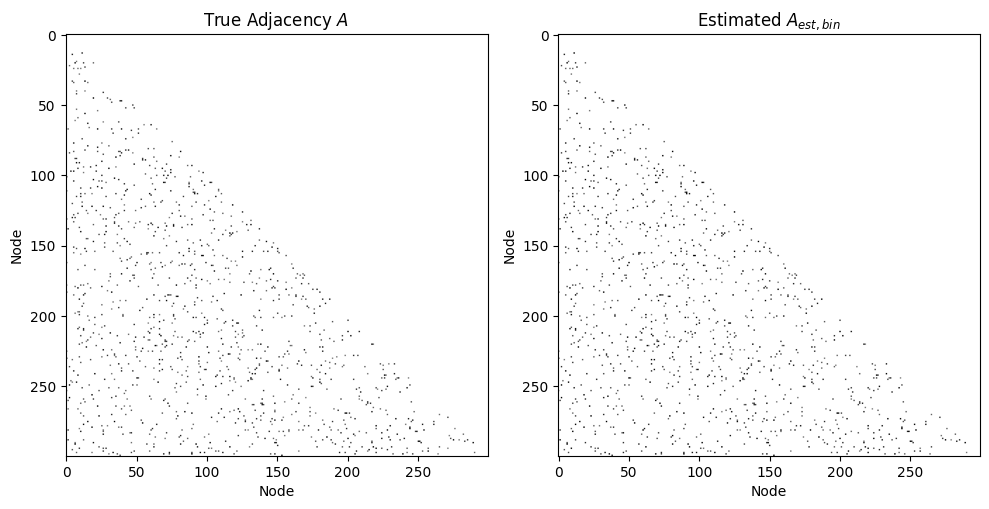

KeyboardInterrupt: 

In [161]:
import dag_utils as utils
import numpy as np
from TopoGreedy import TopoGreedy_refresh
import utils as ut
n = 300
n_runs = 10
shd_list = []

for run in range(n_runs):
    A, dag, X, Theta = utils.simulate_sem(
        n, 1000, 'er', 4*n, permute=False, edge_type='positive',w_range= (0.5,1), noise_type='normal', var=1
    )
    emp_cov = np.cov(X, rowvar=False)
    Topo_output = TopoGreedy_refresh(X, emp_cov, [320], [1e-4], 0.5, 0.01)
    prec = Topo_output['prec']
    A_est = Topo_output['A_est']
    A_est_bin = Topo_output['A_est_bin']
    shd, _, _ = utils.count_accuracy(ut.safe_to_bin(A_est, 0.5), ut.safe_to_bin(A, thr=0.5))
    shd_list.append(shd)
    print(f"Run {run+1}: SHD = {shd}")
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(A, cmap='gray_r', vmin=0, vmax=1)
    axes[0].set_title("True Adjacency $A$")
    axes[0].set_xlabel("Node")
    axes[0].set_ylabel("Node")
    axes[1].imshow(A_est, cmap='gray_r', vmin=0, vmax=1)
    axes[1].set_title("Estimated $A_{est,bin}$")
    axes[1].set_xlabel("Node")
    axes[1].set_ylabel("Node")
    plt.tight_layout()
    plt.show()

print("\nAll SHD values:", shd_list)
print(f"Mean SHD over {n_runs} runs: {np.mean(shd_list):.2f}")

In [6]:
import dag_utils as utils
import numpy as np
from TopoGreedy import TopoGreedy_refresh
import utils as ut
n = 500
n_runs = 10
shd_list = []

for run in range(n_runs):
    A, dag, X, Theta = utils.simulate_sem(
        n, 1000, 'er', 4*n, permute=False, edge_type='positive',w_range= (0.5,1), noise_type='normal', var=1
    )
    emp_cov = np.cov(X, rowvar=False)
    Topo_output = TopoGreedy_refresh(X, emp_cov, [520], [5e-4], 0.5, 0.008)
    prec = Topo_output['prec']
    A_est = Topo_output['A_est']
    A_est_bin = Topo_output['A_est_bin']
    shd, _, _ = utils.count_accuracy(ut.safe_to_bin(A_est, 0.5), ut.safe_to_bin(A, thr=0.5))
    shd_list.append(shd)
    print(f"Run {run+1}: SHD = {shd}")
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(A, cmap='gray_r', vmin=0, vmax=1)
    axes[0].set_title("True Adjacency $A$")
    axes[0].set_xlabel("Node")
    axes[0].set_ylabel("Node")
    axes[1].imshow(A_est, cmap='gray_r', vmin=0, vmax=1)
    axes[1].set_title("Estimated $A_{est,bin}$")
    axes[1].set_xlabel("Node")
    axes[1].set_ylabel("Node")
    plt.tight_layout()
    plt.show()

print("\nAll SHD values:", shd_list)
print(f"Mean SHD over {n_runs} runs: {np.mean(shd_list):.2f}")

KeyboardInterrupt: 

In [7]:
import numpy as np
from typing import Dict, Set, Any, Optional

def parents_dict_to_adj(
    parents: Dict[Any, Set[Any]],
    n: Optional[int] = None,
    dtype: type = float,
    check_bounds: bool = True
) -> np.ndarray:
    """
    Convert a mapping {child: {parent_i, ...}} to an adjacency matrix A
    with convention A[parent, child] = 1.

    Args:
        parents: dict mapping child -> set of parents (ints or np.integer).
        n: optional number of nodes; if None inferred from keys and parent entries.
        dtype: numpy dtype for the returned matrix (default float).
        check_bounds: if True, raises if any index is outside [0, n-1].

    Returns:
        A: (n x n) numpy array adjacency (binary 0/1).
    """
    # collect all node ids appearing as child or parent
    child_ids = list(parents.keys())
    parent_ids = [p for s in parents.values() for p in s]
    all_ids = set(int(x) for x in child_ids) | set(int(x) for x in parent_ids)

    if n is None:
        # infer n as max id + 1 (assumes nodes are 0..n-1)
        n = (max(all_ids) + 1) if all_ids else 0

    A = np.zeros((n, n), dtype=dtype)

    for child, prts in parents.items():
        c = int(child)
        if check_bounds and not (0 <= c < n):
            raise ValueError(f"Child index {c} out of bounds for n={n}.")
        for p in prts:
            pi = int(p)
            if check_bounds and not (0 <= pi < n):
                raise ValueError(f"Parent index {pi} out of bounds for n={n}.")
            A[pi, c] = 1

    return A


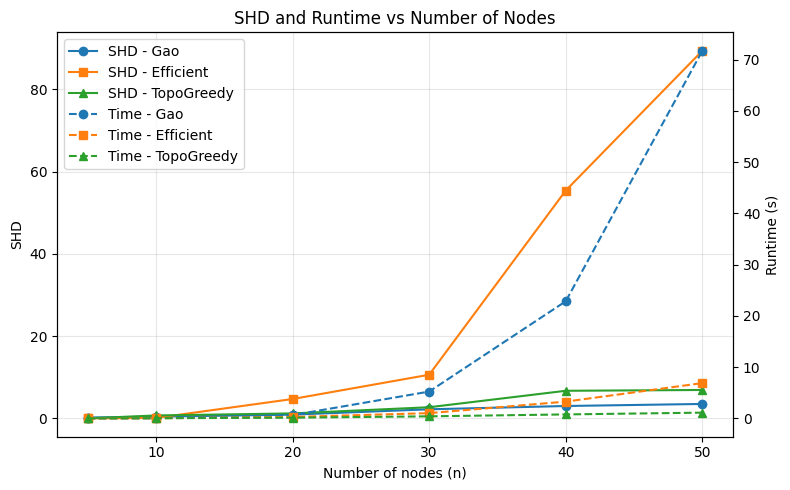

In [1]:
import numpy as np
from sklearn.linear_model import Lasso, LinearRegression
import random
import os
import time
import warnings
warnings.filterwarnings("ignore")


def sample_d(lst, d):
    # Sample <= d things in the list
    n = len(lst)
    if n == 0:
        return []
    parents = []
    probability = min(d / (n + 2), 1 / 2)
    for node in lst:
        if random.random() < probability:
            parents.append(node)
    return parents[:d]


def generate_config(n, d, b_min, b_max):
    """
    Sample a random Bayesian configuration of n vertices with <= d indegree
    """
    order = list(range(n))
    random.shuffle(order)
    coefficient = {i: {} for i in range(n)}
    parents = {i: set() for i in range(n)}
    B = [[0] * n for _ in range(n)]

    for i in range(n):
        node = order[i]
        # prt_sample = sample_d(order[:i], d)
        prt = sample_d(order[:i], d)
        parents[node] = set(prt.copy())
        for p in prt:
            abs_value = (b_min + (b_max - b_min) * random.random())
            sign = (2 * random.randint(0, 1) - 1)
            bij = abs_value * sign
            B[p][node] = coefficient[node][p] = bij


    # B_triu, _ = to_lower_triangular_adj(np.array(B))
    # dag = nx.DiGraph(B_triu)
    # Theta_true = (np.eye(n) - B_triu) @ (np.eye(n) - B_triu).T
    # assert nx.is_directed_acyclic_graph(dag)

    return order, coefficient, parents, np.array(B)


def generate_sample(B, N):
    """
    From the sample configuration, sample a set of values.
    N is the number of samples, B is the coefficient matrix.
    """
    n = B.shape[0]
    raw = np.random.normal(0, 1, [N, n])
    return raw @ np.linalg.inv(np.eye(n) - B)


def combination(lst, d):
    """
    List all subsets (as list) with <= d elements in lst
    """
    if d == 0 or len(lst) == 0:
        return [[]]
    else:
        return combination(lst[1:], d) + [[lst[0]] + j for j in combination(lst[1:], d - 1)]


def choose(lst, d):
    """
    List all subsets (as list) with = d elements in lst
    """
    if d == 0:
        return [[]]
    elif d > len(lst):
        return []
    else:
        return choose(lst[1:], d) + [[lst[0]] + j for j in choose(lst[1:], d - 1)]


#####################################

def lr(data, cand, index):
    '''
    Do OLS linear regression, given the data, candidate of nodes (cand) to
    regress on and the index of the node whom to regress on. Return the
    coefficient (if cand is not empty) and the MSE.
    '''
    assert index not in cand
    N = data.shape[0]
    Y = data[:, [index]]
    X = data[:, cand]

    coef = np.linalg.inv(X.T @ X) @ (X.T @ Y)
    mse = ((X @ coef - Y)**2).sum() / N
    return coef.T, mse


def topo(data, d):
    '''
    Find the topological order given the data and d. Return the topological
    order as a list of nodes.
    '''
    N, n = data.shape
    rem_nodes = list(range(n))
    top = [np.argmin(sum(data**2))]
    rem_nodes.remove(top[0])

    for _ in range(n - 2):
        best_mse = 1_000_000
        next_node = -1
        for r in rem_nodes:
            mse = 1_000_000
            for cand in combination(top, d):
                coef, mse1 = lr(data, cand, r)
                mse = min(mse, mse1)
            if mse < best_mse:
                best_mse = mse
                next_node = r
        rem_nodes.remove(next_node)
        top.append(next_node)

    top.append(rem_nodes[0])
    return top


def learning_parents_g(data, order, d):
    '''
    Using Gao et al. (2022)'s algorithm to find the parents given the
    topological order. Return the parents for each node as a dictionary.
    '''
    n = data.shape[1]
    parents = {i: set() for i in range(n)}

    for i in range(n):
        if i == 0:
            continue
        prev = order[:i]
        node = order[i]
        mse = 1_000_000
        parent_superset = None

        # Find C_j to be argmin(v_jc)
        for cand in combination(prev, d):
            coef, mse1 = lr(data, cand, node)
            if mse1 < mse:
                mse = mse1
                parent_superset = cand

        parent = set()
        for pa in parent_superset:
            parentm1 = parent_superset.copy()
            parentm1.remove(pa)

            coef, mse1 = lr(data, parentm1, node)
            if abs(mse-mse1) >= gamma:
                parent.add(pa)
        parents[node] = parent

    return parents



def lasso(data, cand, index):
    '''
    Run LASSO regression on given data.
    data: data matrix
    cand: candidate predictors
    index: target node index
    lambda_n: regularization parameter
    '''
    N = data.shape[0]
    Y = data[:, [index]]
    X = data[:, cand]
    X1 = data[:, cand]
    Y1 = data[:, [index]]
    lambda_n = 0.01

    if cand == []:
        return [], (Y**2).sum() / Y.size

    reg = Lasso(fit_intercept=False, alpha=lambda_n, copy_X=False).fit(X, Y)
    coef = reg.coef_
    mse = ((X @ np.array([coef]).T - Y) ** 2).sum() / N
    return coef, mse



def learning_parents_e(data, d):
    """
    Learn the parents by LASSO (efficient algorithm).
    Returns the topological order (top) and a dict of parents.
    Expects a global b_min and a function lasso(data, cand, index).
    """
    N, n = data.shape
    rem_nodes = list(range(n))
    top = [np.argmin(sum(data**2))]
    rem_nodes.remove(top[0])

    parents = {i: set() for i in range(n)}

    for _ in range(n - 1):
        best_node = -1
        best_mse = 1_000_000
        parent = set()

        for node in rem_nodes:
            coef, mse = lasso(data, top, node)
            if mse <= best_mse:
                best_mse = mse
                best_node = node
                # keep strong coefficients and cap at d parents
                parent = set(n for c, n in zip(coef, top) if abs(c) > b_min / 2)
                parent = set(list(parent)[:d])

        parents[best_node] = parent
        top.append(best_node)
        rem_nodes.remove(best_node)

    return top, parents


import utils
import matplotlib.pyplot as plt
from time import perf_counter
from utils import to_bin, parents_dict_to_adj, count_accuracy
from TopoGreedy import TopoGreedy_refresh

import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter

# ---- experiment knobs (as shown in the image) ----
n = 25      # Choose any n you want
d = 4        # Choose any d you want
b_min = 0.5
b_max = 2.0  # Choose any b_max you want
sigma = 1.0  # (placeholder; set as needed)
gamma = b_min**2 / 2   # As Gao et al. 2022
repeat = 10  # Number of trials

# ---- settings ----
node_grid = [5, 10, 20, 30, 40, 50]
SAMPLES_PER_TRIAL = 1000       # fixed N per trial
REPS = repeat                  # reuse your 'repeat' value (e.g., 10)
thr = 0.5                      # threshold to binarize B

# Storage
shd_gao_means, shd_eff_means, shd_topo_means = [], [], []
tim_gao_means, tim_eff_means, tim_topo_means = [], [], []

for n_nodes in node_grid:
    shd_gao_list, shd_eff_list, shd_topo_list = [], [], []
    tim_gao_list, tim_eff_list, tim_topo_list = [], [], []

    for j in range(REPS):
        # --- synthesize one DAG + data for this n_nodes ---
        order, coeff, true_parents, B = generate_config(n_nodes, d, b_min, b_max)
        X = np.array(generate_sample(B, SAMPLES_PER_TRIAL))
        emp_cov = np.cov(X, rowvar=False)

        # Ground-truth binary adjacency
        B_true_bin = to_bin(B, thr=thr)

        # --- Gao (needs topo order first) ---
        order_topo = topo(X, d)
        t0 = perf_counter()
        g_parents = learning_parents_g(X, order_topo, d)
        t1 = perf_counter()
        B_est_g = parents_dict_to_adj(g_parents)
        shd_gao_list.append(count_accuracy(B_true_bin, B_est_g)[0])
        tim_gao_list.append(t1 - t0)

        # --- Efficient ---
        t0 = perf_counter()
        e_parents = learning_parents_e(X, d)[1]
        t1 = perf_counter()
        B_est_e = parents_dict_to_adj(e_parents)
        shd_eff_list.append(count_accuracy(B_true_bin, B_est_e)[0])
        tim_eff_list.append(t1 - t0)

        # --- TopoGreedy (already returns binary A) ---
        t0 = perf_counter()
        topo_res = TopoGreedy_refresh(
            X, emp_cov,
            k_list=[30], threshold_list=[1e-4],
            topo_thr=0.5, refresh_every=0.1
        )
        t1 = perf_counter()
        B_est_topo = topo_res['A_est_bin']
        shd_topo_list.append(count_accuracy(B_true_bin, B_est_topo)[0])
        tim_topo_list.append(t1 - t0)

    # Aggregate per n
    shd_gao_means.append(np.mean(shd_gao_list))
    shd_eff_means.append(np.mean(shd_eff_list))
    shd_topo_means.append(np.mean(shd_topo_list))

    tim_gao_means.append(np.mean(tim_gao_list))
    tim_eff_means.append(np.mean(tim_eff_list))
    tim_topo_means.append(np.mean(tim_topo_list))

# ---- Plot: dual y-axes (left: SHD, right: time) ----
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()

# Left axis: SHD
lns1 = ax1.plot(node_grid, shd_gao_means, marker='o', label='SHD - Gao')
lns2 = ax1.plot(node_grid, shd_eff_means, marker='s', label='SHD - Efficient')
lns3 = ax1.plot(node_grid, shd_topo_means, marker='^', label='SHD - TopoGreedy')
ax1.set_xlabel('Number of nodes (n)')
ax1.set_ylabel('SHD')
ax1.grid(True, which='both', axis='both', alpha=0.3)

# Right axis: runtime (seconds)
lns4 = ax2.plot(node_grid, tim_gao_means, marker='o', linestyle='--', label='Time - Gao')
lns5 = ax2.plot(node_grid, tim_eff_means, marker='s', linestyle='--', label='Time - Efficient')
lns6 = ax2.plot(node_grid, tim_topo_means, marker='^', linestyle='--', label='Time - TopoGreedy')
ax2.set_ylabel('Runtime (s)')

# One combined legend
lines = lns1 + lns2 + lns3 + lns4 + lns5 + lns6
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')

plt.title('SHD and Runtime vs Number of Nodes')
plt.tight_layout()
plt.show()


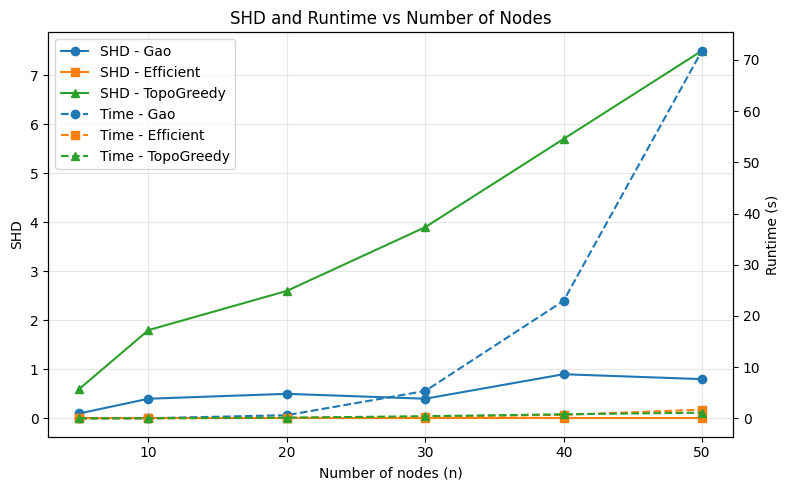

In [2]:
import numpy as np
from sklearn.linear_model import Lasso, LinearRegression
import random
import os
import time
import warnings
warnings.filterwarnings("ignore")


def sample_d(lst, d):
    # Sample <= d things in the list
    n = len(lst)
    if n == 0:
        return []
    parents = []
    probability = min(d / (n + 2), 1 / 2)
    for node in lst:
        if random.random() < probability:
            parents.append(node)
    return parents[:d]


def generate_config(n, d, b_min, b_max):
    """
    Sample a random Bayesian configuration of n vertices with <= d indegree
    """
    order = list(range(n))
    random.shuffle(order)
    coefficient = {i: {} for i in range(n)}
    parents = {i: set() for i in range(n)}
    B = [[0] * n for _ in range(n)]

    for i in range(n):
        node = order[i]
        # prt_sample = sample_d(order[:i], d)
        prt = sample_d(order[:i], d)
        parents[node] = set(prt.copy())
        for p in prt:
            abs_value = (b_min + (b_max - b_min) * random.random())
            sign = (2 * random.randint(0, 1) - 1)
            bij = abs_value * sign
            B[p][node] = coefficient[node][p] = bij


    # B_triu, _ = to_lower_triangular_adj(np.array(B))
    # dag = nx.DiGraph(B_triu)
    # Theta_true = (np.eye(n) - B_triu) @ (np.eye(n) - B_triu).T
    # assert nx.is_directed_acyclic_graph(dag)

    return order, coefficient, parents, np.array(B)


def generate_sample(B, N):
    """
    From the sample configuration, sample a set of values.
    N is the number of samples, B is the coefficient matrix.
    """
    n = B.shape[0]
    raw = np.random.normal(0, 1, [N, n])
    return raw @ np.linalg.inv(np.eye(n) - B)


def combination(lst, d):
    """
    List all subsets (as list) with <= d elements in lst
    """
    if d == 0 or len(lst) == 0:
        return [[]]
    else:
        return combination(lst[1:], d) + [[lst[0]] + j for j in combination(lst[1:], d - 1)]


def choose(lst, d):
    """
    List all subsets (as list) with = d elements in lst
    """
    if d == 0:
        return [[]]
    elif d > len(lst):
        return []
    else:
        return choose(lst[1:], d) + [[lst[0]] + j for j in choose(lst[1:], d - 1)]


#####################################

def lr(data, cand, index):
    '''
    Do OLS linear regression, given the data, candidate of nodes (cand) to
    regress on and the index of the node whom to regress on. Return the
    coefficient (if cand is not empty) and the MSE.
    '''
    assert index not in cand
    N = data.shape[0]
    Y = data[:, [index]]
    X = data[:, cand]

    coef = np.linalg.inv(X.T @ X) @ (X.T @ Y)
    mse = ((X @ coef - Y)**2).sum() / N
    return coef.T, mse


def topo(data, d):
    '''
    Find the topological order given the data and d. Return the topological
    order as a list of nodes.
    '''
    N, n = data.shape
    rem_nodes = list(range(n))
    top = [np.argmin(sum(data**2))]
    rem_nodes.remove(top[0])

    for _ in range(n - 2):
        best_mse = 1_000_000
        next_node = -1
        for r in rem_nodes:
            mse = 1_000_000
            for cand in combination(top, d):
                coef, mse1 = lr(data, cand, r)
                mse = min(mse, mse1)
            if mse < best_mse:
                best_mse = mse
                next_node = r
        rem_nodes.remove(next_node)
        top.append(next_node)

    top.append(rem_nodes[0])
    return top


def learning_parents_g(data, order, d):
    '''
    Using Gao et al. (2022)'s algorithm to find the parents given the
    topological order. Return the parents for each node as a dictionary.
    '''
    n = data.shape[1]
    parents = {i: set() for i in range(n)}

    for i in range(n):
        if i == 0:
            continue
        prev = order[:i]
        node = order[i]
        mse = 1_000_000
        parent_superset = None

        # Find C_j to be argmin(v_jc)
        for cand in combination(prev, d):
            coef, mse1 = lr(data, cand, node)
            if mse1 < mse:
                mse = mse1
                parent_superset = cand

        parent = set()
        for pa in parent_superset:
            parentm1 = parent_superset.copy()
            parentm1.remove(pa)

            coef, mse1 = lr(data, parentm1, node)
            if abs(mse-mse1) >= gamma:
                parent.add(pa)
        parents[node] = parent

    return parents



def lasso(data, cand, index):
    '''
    Run LASSO regression on given data.
    data: data matrix
    cand: candidate predictors
    index: target node index
    lambda_n: regularization parameter
    '''
    N = data.shape[0]
    Y = data[:, [index]]
    X = data[:, cand]
    X1 = data[:, cand]
    Y1 = data[:, [index]]
    lambda_n = 0.01

    if cand == []:
        return [], (Y**2).sum() / Y.size

    reg = Lasso(fit_intercept=False, alpha=lambda_n, copy_X=False).fit(X, Y)
    coef = reg.coef_
    mse = ((X @ np.array([coef]).T - Y) ** 2).sum() / N
    return coef, mse



def learning_parents_e(data, d):
    """
    Learn the parents by LASSO (efficient algorithm).
    Returns the topological order (top) and a dict of parents.
    Expects a global b_min and a function lasso(data, cand, index).
    """
    N, n = data.shape
    rem_nodes = list(range(n))
    top = [np.argmin(sum(data**2))]
    rem_nodes.remove(top[0])

    parents = {i: set() for i in range(n)}

    for _ in range(n - 1):
        best_node = -1
        best_mse = 1_000_000
        parent = set()

        for node in rem_nodes:
            coef, mse = lasso(data, top, node)
            if mse <= best_mse:
                best_mse = mse
                best_node = node
                # keep strong coefficients and cap at d parents
                parent = set(n for c, n in zip(coef, top) if abs(c) > b_min / 2)
                parent = set(list(parent)[:d])

        parents[best_node] = parent
        top.append(best_node)
        rem_nodes.remove(best_node)

    return top, parents


import utils
import matplotlib.pyplot as plt
from time import perf_counter
from utils import to_bin, parents_dict_to_adj, count_accuracy
from TopoGreedy import TopoGreedy_refresh

import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter

# ---- experiment knobs (as shown in the image) ----
n = 25      # Choose any n you want
d = 4        # Choose any d you want
b_min = 0.5
b_max = 1.0  # Choose any b_max you want
sigma = 1.0  # (placeholder; set as needed)
gamma = b_min**2 / 2   # As Gao et al. 2022
repeat = 10  # Number of trials

# ---- settings ----
node_grid = [5, 10, 20, 30, 40, 50]
SAMPLES_PER_TRIAL = 1000       # fixed N per trial
REPS = repeat                  # reuse your 'repeat' value (e.g., 10)
thr = 0.5                      # threshold to binarize B

# Storage
shd_gao_means, shd_eff_means, shd_topo_means = [], [], []
tim_gao_means, tim_eff_means, tim_topo_means = [], [], []

for n_nodes in node_grid:
    shd_gao_list, shd_eff_list, shd_topo_list = [], [], []
    tim_gao_list, tim_eff_list, tim_topo_list = [], [], []

    for j in range(REPS):
        # --- synthesize one DAG + data for this n_nodes ---
        order, coeff, true_parents, B = generate_config(n_nodes, d, b_min, b_max)
        X = np.array(generate_sample(B, SAMPLES_PER_TRIAL))
        emp_cov = np.cov(X, rowvar=False)

        # Ground-truth binary adjacency
        B_true_bin = to_bin(B, thr=thr)

        # --- Gao (needs topo order first) ---
        order_topo = topo(X, d)
        t0 = perf_counter()
        g_parents = learning_parents_g(X, order_topo, d)
        t1 = perf_counter()
        B_est_g = parents_dict_to_adj(g_parents)
        shd_gao_list.append(count_accuracy(B_true_bin, B_est_g)[0])
        tim_gao_list.append(t1 - t0)

        # --- Efficient ---
        t0 = perf_counter()
        e_parents = learning_parents_e(X, d)[1]
        t1 = perf_counter()
        B_est_e = parents_dict_to_adj(e_parents)
        shd_eff_list.append(count_accuracy(B_true_bin, B_est_e)[0])
        tim_eff_list.append(t1 - t0)

        # --- TopoGreedy (already returns binary A) ---
        t0 = perf_counter()
        topo_res = TopoGreedy_refresh(
            X, emp_cov,
            k_list=[30], threshold_list=[1e-4],
            topo_thr=0.5, refresh_every=0.1
        )
        t1 = perf_counter()
        B_est_topo = topo_res['A_est_bin']
        shd_topo_list.append(count_accuracy(B_true_bin, B_est_topo)[0])
        tim_topo_list.append(t1 - t0)

    # Aggregate per n
    shd_gao_means.append(np.mean(shd_gao_list))
    shd_eff_means.append(np.mean(shd_eff_list))
    shd_topo_means.append(np.mean(shd_topo_list))

    tim_gao_means.append(np.mean(tim_gao_list))
    tim_eff_means.append(np.mean(tim_eff_list))
    tim_topo_means.append(np.mean(tim_topo_list))

# ---- Plot: dual y-axes (left: SHD, right: time) ----
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()

# Left axis: SHD
lns1 = ax1.plot(node_grid, shd_gao_means, marker='o', label='SHD - Gao')
lns2 = ax1.plot(node_grid, shd_eff_means, marker='s', label='SHD - Efficient')
lns3 = ax1.plot(node_grid, shd_topo_means, marker='^', label='SHD - TopoGreedy')
ax1.set_xlabel('Number of nodes (n)')
ax1.set_ylabel('SHD')
ax1.grid(True, which='both', axis='both', alpha=0.3)

# Right axis: runtime (seconds)
lns4 = ax2.plot(node_grid, tim_gao_means, marker='o', linestyle='--', label='Time - Gao')
lns5 = ax2.plot(node_grid, tim_eff_means, marker='s', linestyle='--', label='Time - Efficient')
lns6 = ax2.plot(node_grid, tim_topo_means, marker='^', linestyle='--', label='Time - TopoGreedy')
ax2.set_ylabel('Runtime (s)')

# One combined legend
lines = lns1 + lns2 + lns3 + lns4 + lns5 + lns6
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')

plt.title('SHD and Runtime vs Number of Nodes')
plt.tight_layout()
plt.show()


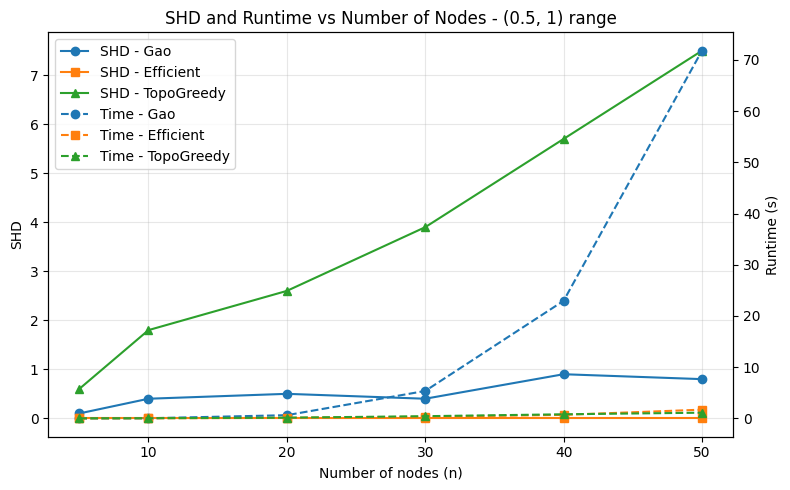

In [4]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()

# Left axis: SHD
lns1 = ax1.plot(node_grid, shd_gao_means, marker='o', label='SHD - Gao')
lns2 = ax1.plot(node_grid, shd_eff_means, marker='s', label='SHD - Efficient')
lns3 = ax1.plot(node_grid, shd_topo_means, marker='^', label='SHD - TopoGreedy')
ax1.set_xlabel('Number of nodes (n)')
ax1.set_ylabel('SHD')
ax1.grid(True, which='both', axis='both', alpha=0.3)

# Right axis: runtime (seconds)
lns4 = ax2.plot(node_grid, tim_gao_means, marker='o', linestyle='--', label='Time - Gao')
lns5 = ax2.plot(node_grid, tim_eff_means, marker='s', linestyle='--', label='Time - Efficient')
lns6 = ax2.plot(node_grid, tim_topo_means, marker='^', linestyle='--', label='Time - TopoGreedy')
ax2.set_ylabel('Runtime (s)')

# One combined legend
lines = lns1 + lns2 + lns3 + lns4 + lns5 + lns6
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')

plt.title('SHD and Runtime vs Number of Nodes - (0.5, 1) range')
plt.tight_layout()
plt.show()